In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dask.distributed import Client
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    ClusterlessClassifier,
)

from src.figure_utilities import (
    PAGE_HEIGHT,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

In [3]:
client = Client(processes=True, n_workers=16, threads_per_worker=4, memory_limit="50GB")

## Examples

In [5]:
import copy

from src.load_data import load_data
from src.parameters import (
    ANIMALS,
    FIGURE_DIR,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    continuous_transition_types,
    discrete_diag,
    knot_spacing,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
    spike_model_penalty,
)
from loren_frank_data_processing import (
    get_multiunit_dataframe,
    get_multiunit_dataframe2,
)

MILLISECONDS_TO_SECONDS = 1000


def plot_ripple_figure_1D(epoch_key, ripple_number):
    data = load_data(epoch_key)

    multiunit_times = [
        get_multiunit_dataframe(tetrode_key, ANIMALS)
        for tetrode_key in data["tetrode_info"].index
    ]
    if multiunit_times[0] is None:
        multiunit_times = [
            get_multiunit_dataframe2(tetrode_key, ANIMALS)
            for tetrode_key in data["tetrode_info"].index
        ]

    # Fit
    is_training = data["position_info"].speed > 4
    position = data["position_info"].loc[:, "linear_position2"]
    track_labels = data["position_info"].arm_name

    classifier = ClusterlessClassifier(
        place_bin_size=place_bin_size,
        movement_var=movement_var,
        replay_speed=replay_speed,
        discrete_transition_diag=discrete_diag,
        continuous_transition_types=continuous_transition_types,
        model=model,
        model_kwargs=model_kwargs,
    )
    classifier.fit(
        position, data["multiunit"], is_training=is_training, track_labels=track_labels
    )

    # Predict
    time_slice = slice(
        *data["ripple_times"].loc[ripple_number, ["start_time", "end_time"]]
    )
    m = data["multiunit"].sel(time=time_slice)

    results_1D = classifier.predict(m, m.time - m.time[0]).assign_coords(
        state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
    )

    # Plot
    fig, axes = plt.subplots(
        3,
        1,
        sharex=True,
        constrained_layout=True,
        figsize=(8, 6),
        gridspec_kw={"height_ratios": [1, 1, 3]},
    )

    n_tetrodes = len(multiunit_times)
    ripple_duration = (
        MILLISECONDS_TO_SECONDS
        * (time_slice.stop - time_slice.start)
        / np.timedelta64(1, "s")
    )

    axes[0].eventplot(
        [
            MILLISECONDS_TO_SECONDS
            * (multiunit.loc[time_slice].index - time_slice.start)
            / np.timedelta64(1, "s")
            for multiunit in multiunit_times
        ],
        color="black",
    )

    axes[0].set_xlim((0, ripple_duration))
    axes[0].set_xticks((0, ripple_duration))

    axes[0].set_yticks((0, n_tetrodes))
    axes[0].set_ylabel("Tetrodes")

    probability = results_1D.acausal_posterior.sum(["position"])

    for state, prob in zip(results_1D.state.values, probability.values.T):
        axes[1].plot(
            MILLISECONDS_TO_SECONDS * probability.time / np.timedelta64(1, "s"),
            prob,
            linewidth=3,
            color=STATE_COLORS[state],
        )

    axes[1].set_ylim((0, 1.01))
    axes[1].set_yticks((0, 1))
    axes[1].set_ylabel("Probability")

    cmap = copy.copy(plt.cm.get_cmap("viridis"))
    cmap.set_bad(color="lightgrey", alpha=1.0)
    (
        results_1D.assign_coords(
            time=lambda ds: MILLISECONDS_TO_SECONDS * ds.time / np.timedelta64(1, "s")
        )
        .acausal_posterior.sum("state")
        .where(classifier.is_track_interior_)
        .plot(
            x="time",
            y="position",
            robust=True,
            add_colorbar=False,
            zorder=0,
            rasterized=True,
            cmap=cmap,
        )
    )

    ripple_position = data["position_info"].loc[time_slice, "linear_position2"].mean()
    max_time = (
        MILLISECONDS_TO_SECONDS * probability.time / np.timedelta64(1, "s")
    ).max()
    axes[2].annotate(
        "",
        xy=(max_time, ripple_position),
        xycoords="data",
        xytext=(max_time + ripple_duration * 0.04, ripple_position),
        textcoords="data",
        arrowprops=dict(shrink=0.00, color="red"),
        horizontalalignment="left",
        verticalalignment="center",
        color="red",
        zorder=200,
    )
    axes[2].set_xlim((0, max_time))
    axes[2].set_xticks((0, np.round(ripple_duration).astype(int)))
    axes[2].set_xlabel("Time [ms]")

    arm_min_max = (
        data["position_info"]
        .groupby("arm_name")
        .linear_position2.aggregate(["min", "max"])
    )
    axes[2].text(
        max_time + 1,
        arm_min_max.loc["Center Arm", "min"],
        "C",
        ha="left",
        va="bottom",
        weight="bold",
    )
    axes[2].text(
        max_time + 1,
        arm_min_max.loc["Center Arm", "max"],
        "*",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[2].text(
        max_time + 1,
        arm_min_max.loc["Right Arm", "max"],
        "R",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[2].text(
        max_time + 1,
        arm_min_max.loc["Right Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
    )
    axes[2].text(
        max_time + 1,
        arm_min_max.loc["Left Arm", "max"],
        "L",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[2].text(
        max_time + 1,
        arm_min_max.loc["Left Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
    )
    axes[2].set_ylabel("Position [cm]")

    sns.despine()

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:34144 remote=tcp://127.0.0.1:43227>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:34146 remote=tcp://127.0.0.1:43227>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:34148 remote=tcp://127.0.0.1:43227>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:34150 remote=tcp://127.0.0.1:43227>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:34152 remote=tcp://127.0.0.1:43227>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:34154 remote=tcp://127.0.0.1:43227>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:34156 remote=tcp://127.0.0.1:43227>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:34158 remote=tcp://127.0.0.1:43227>
distribu

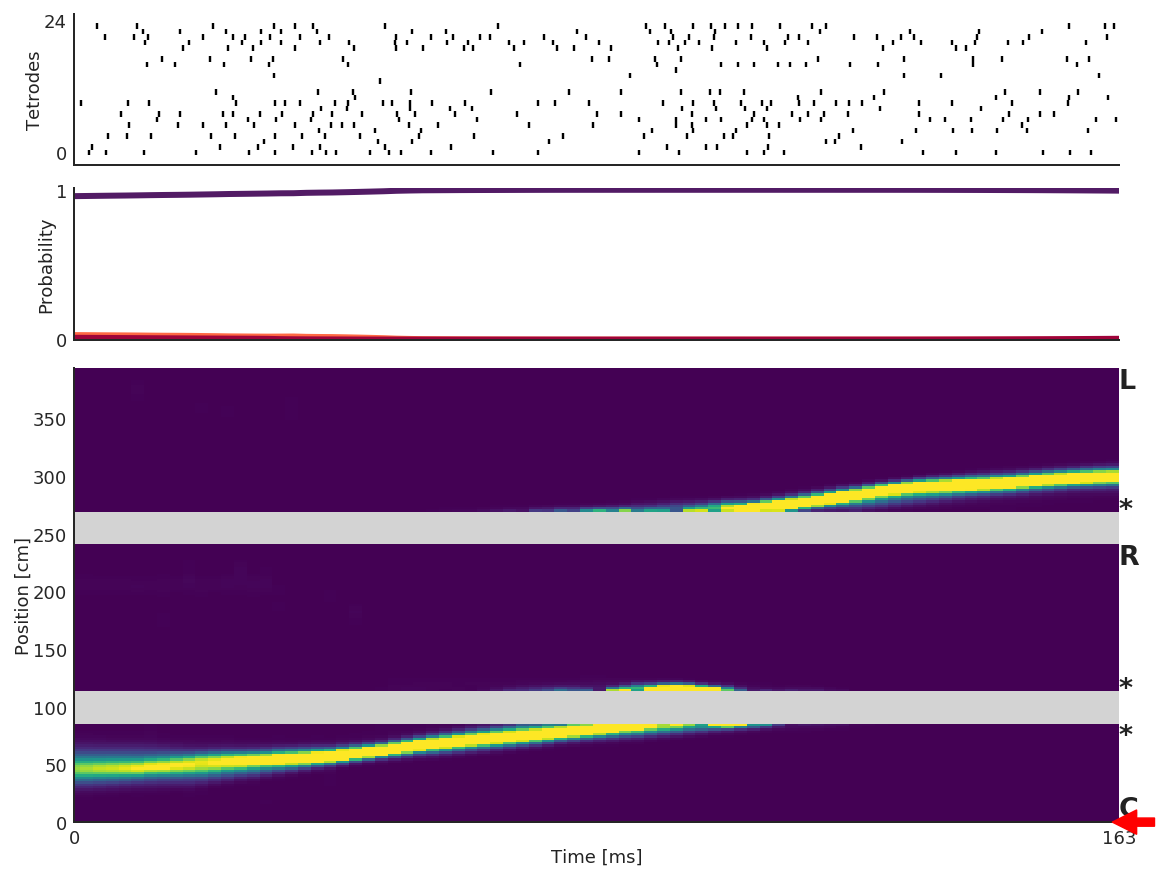

In [6]:
epoch_key = "remy", 36, 2
ripple_number = 20

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-02.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-03.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-04.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-06.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-07.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-09.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-D

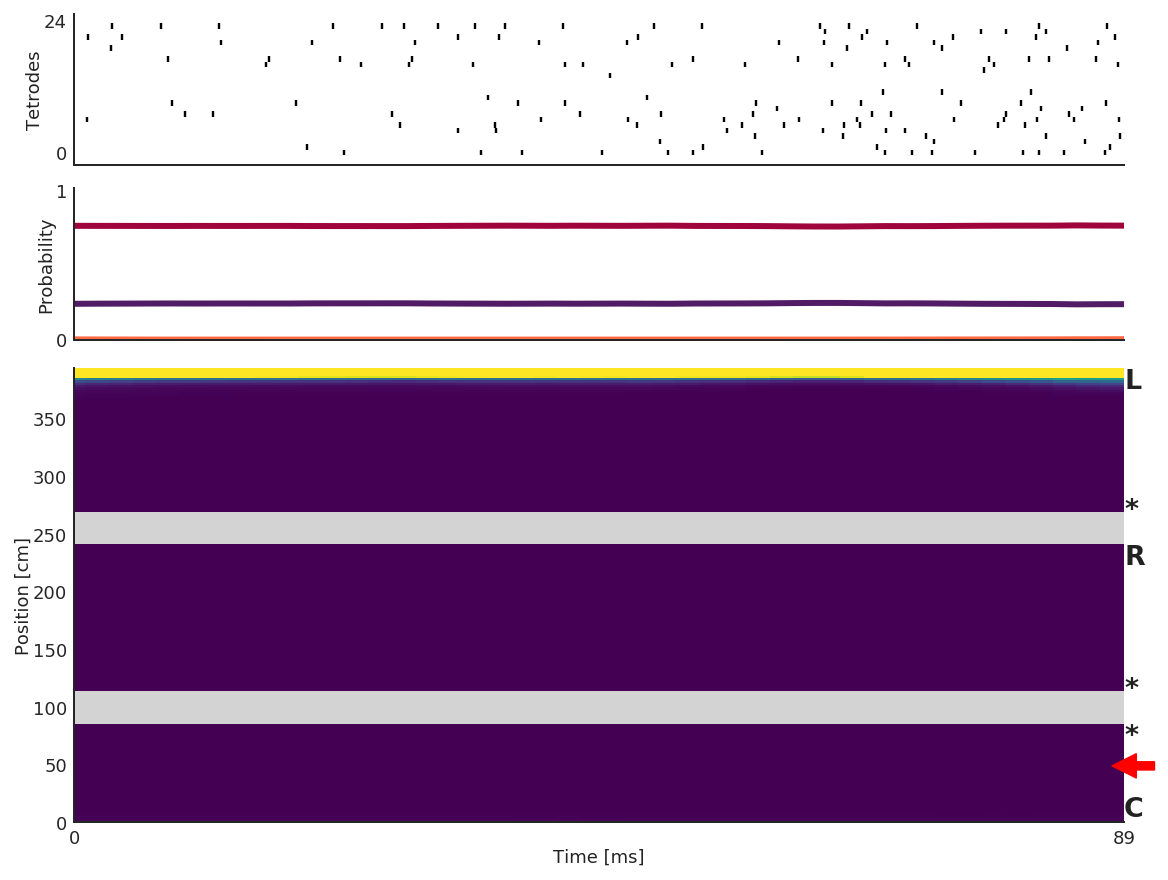

In [7]:
epoch_key = "remy", 36, 2
ripple_number = 4

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-02.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-03.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-04.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-06.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-07.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-09.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-D

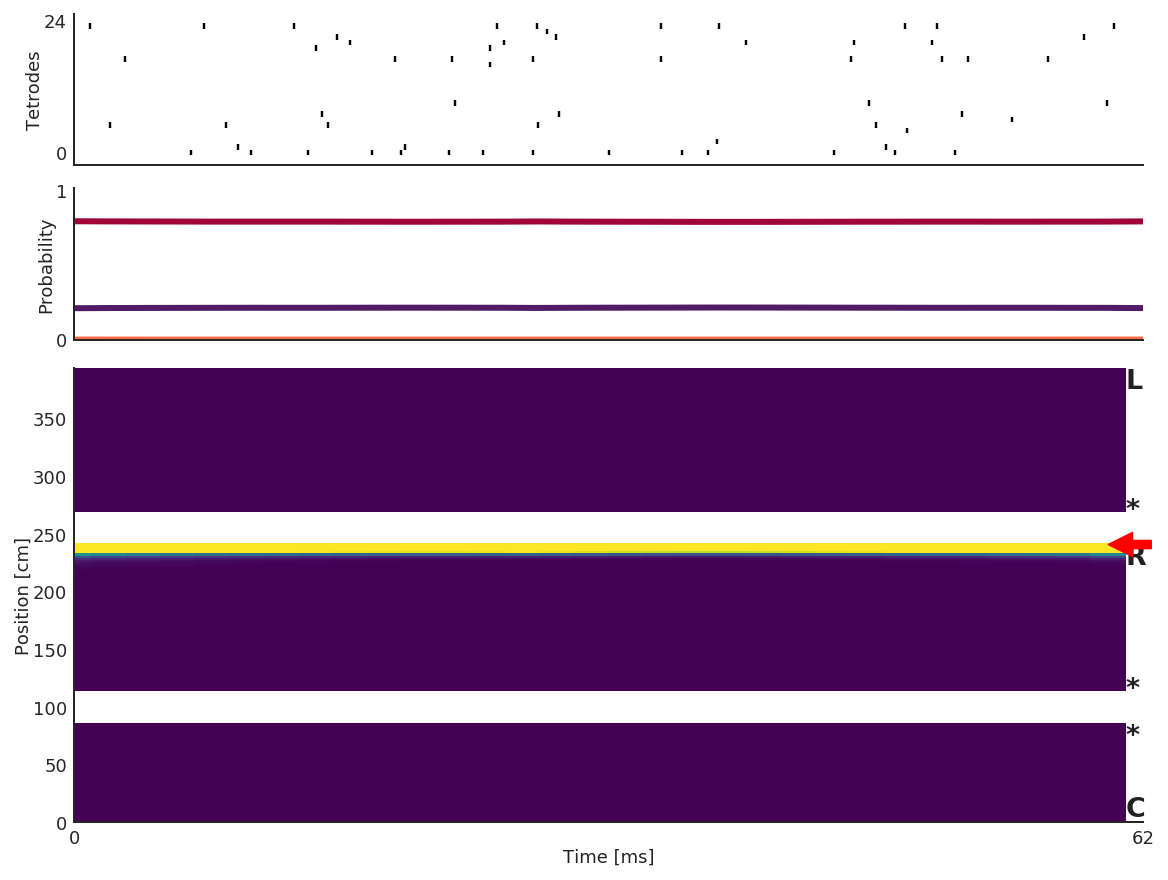

In [7]:
epoch_key = 'remy', 36, 2
ripple_number = 33

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks37-02.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks37-03.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks37-04.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks37-06.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks37-07.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks37-09.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-D

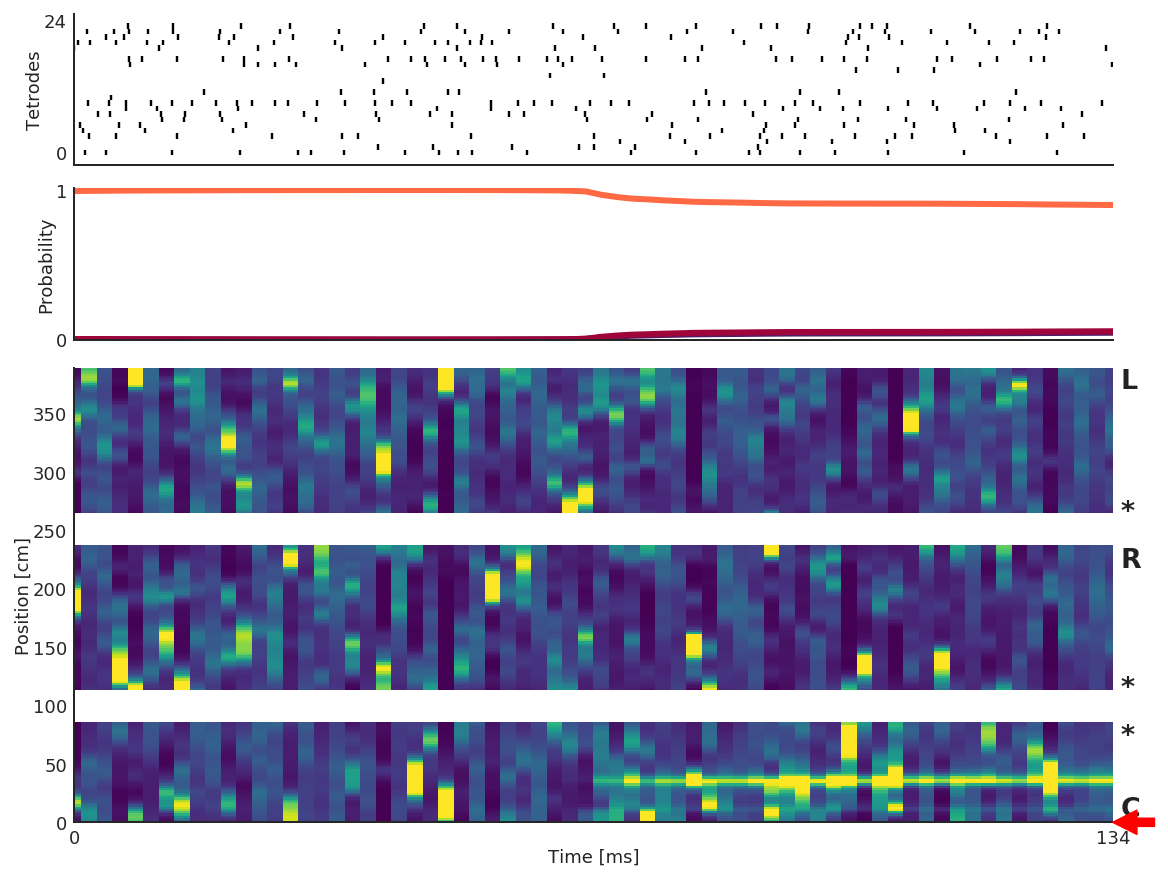

In [8]:
epoch_key = 'remy', 37, 2
ripple_number = 7

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


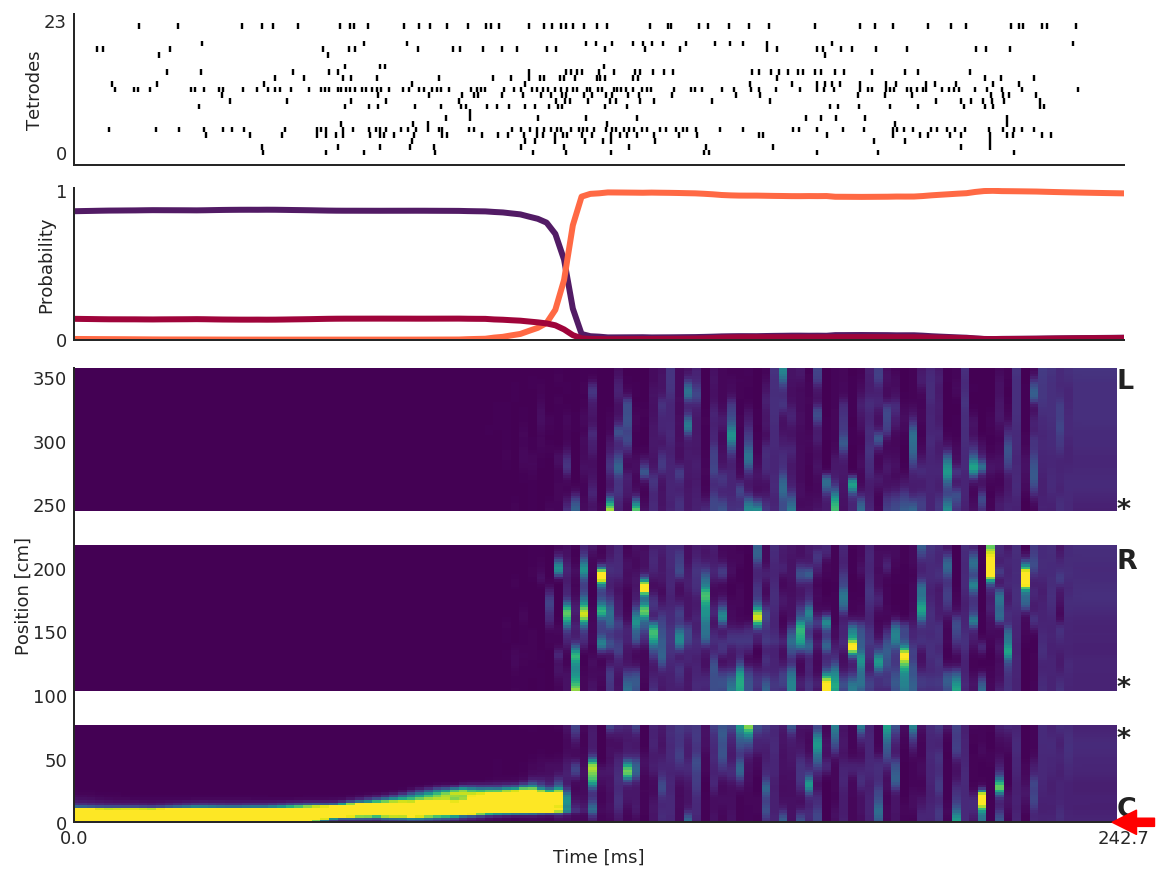

In [9]:
epoch_key = 'bon', 3, 6
ripple_number = 181

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-02.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-03.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-04.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-06.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-07.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-09.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-D

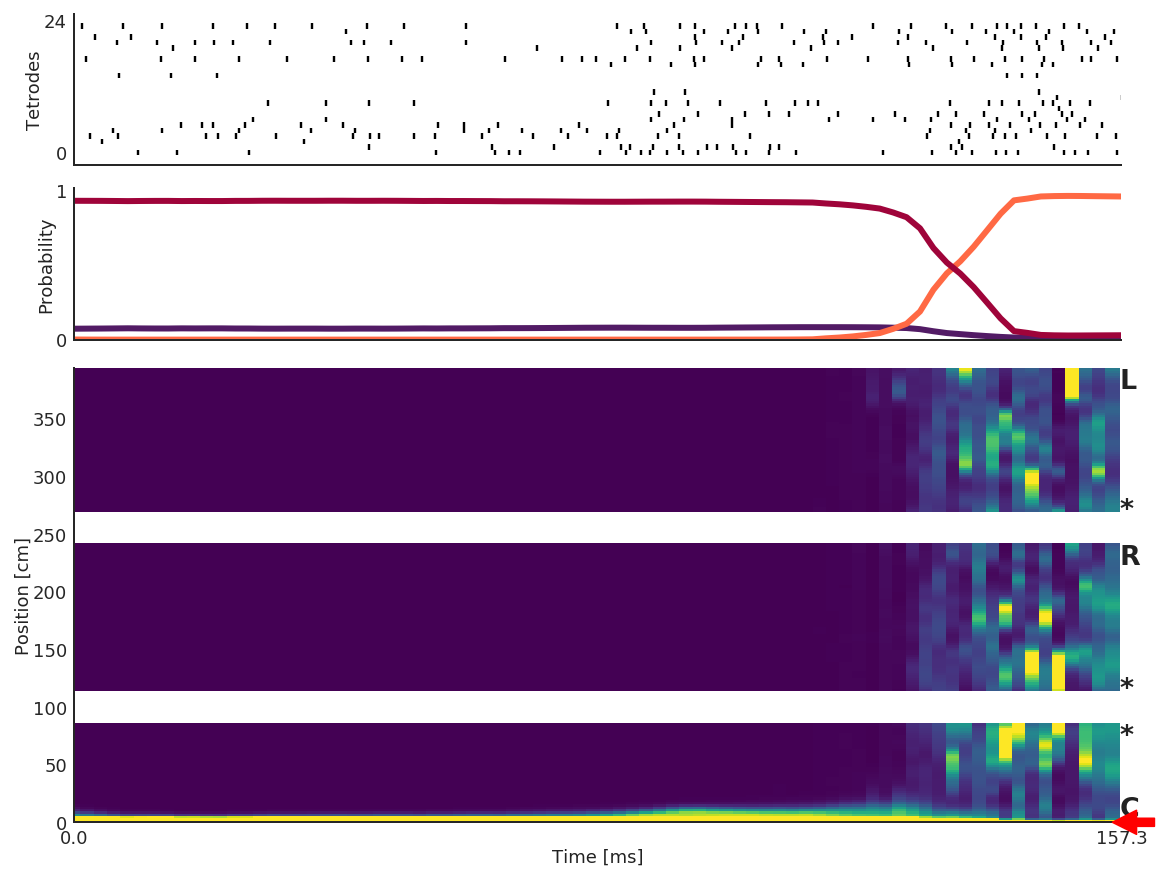

In [10]:
epoch_key = 'remy', 36, 2
ripple_number = 252

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-02.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-03.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-04.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-06.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-07.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-09.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-D

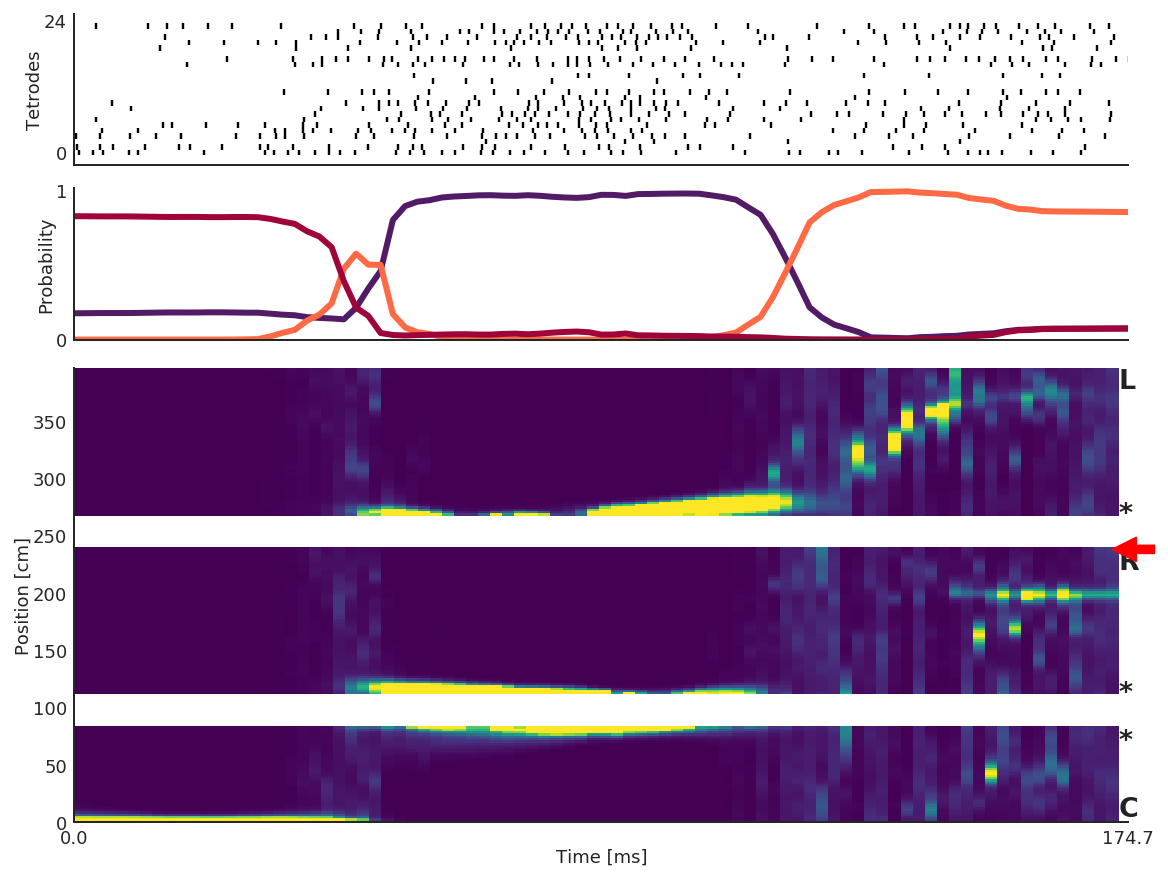

In [11]:
epoch_key = 'remy', 35, 4
ripple_number = 57

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-02.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-03.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-04.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-06.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-07.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-09.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-D

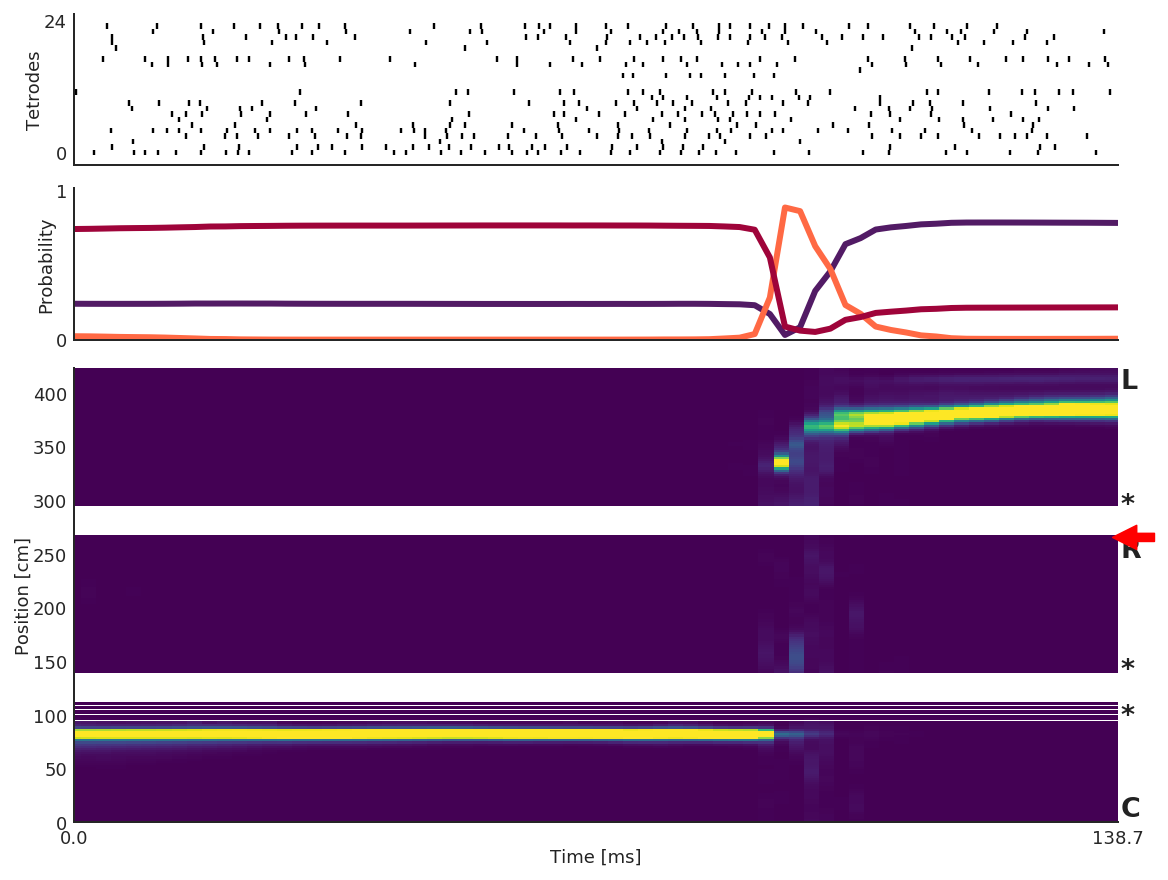

In [12]:
epoch_key = 'remy', 35, 2
ripple_number = 157

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO05.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO05.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO05.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO05.mat
No DIO file found, inferring correct inbound/outbound from task rules


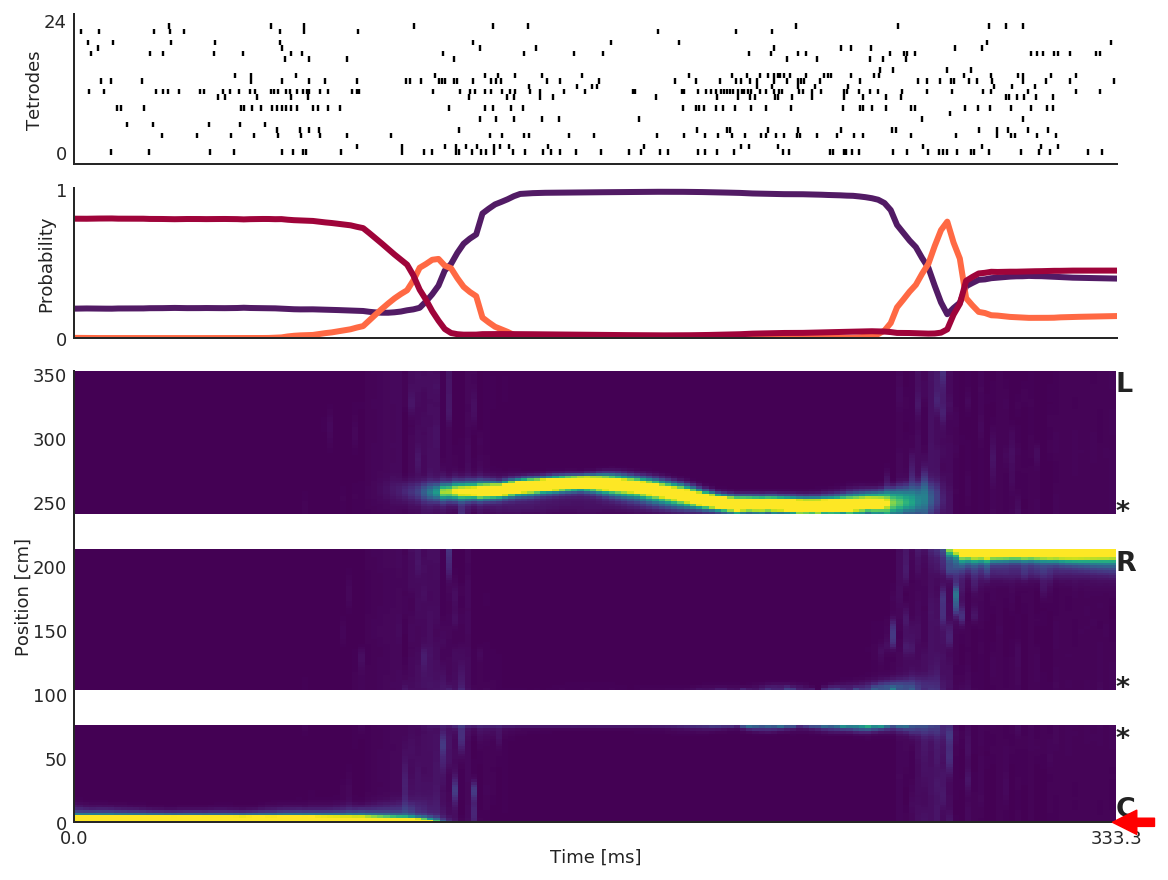

In [13]:
epoch_key = 'bon', 5, 4
ripple_number = 75

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-02.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-03.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-04.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-06.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-07.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-09.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-D

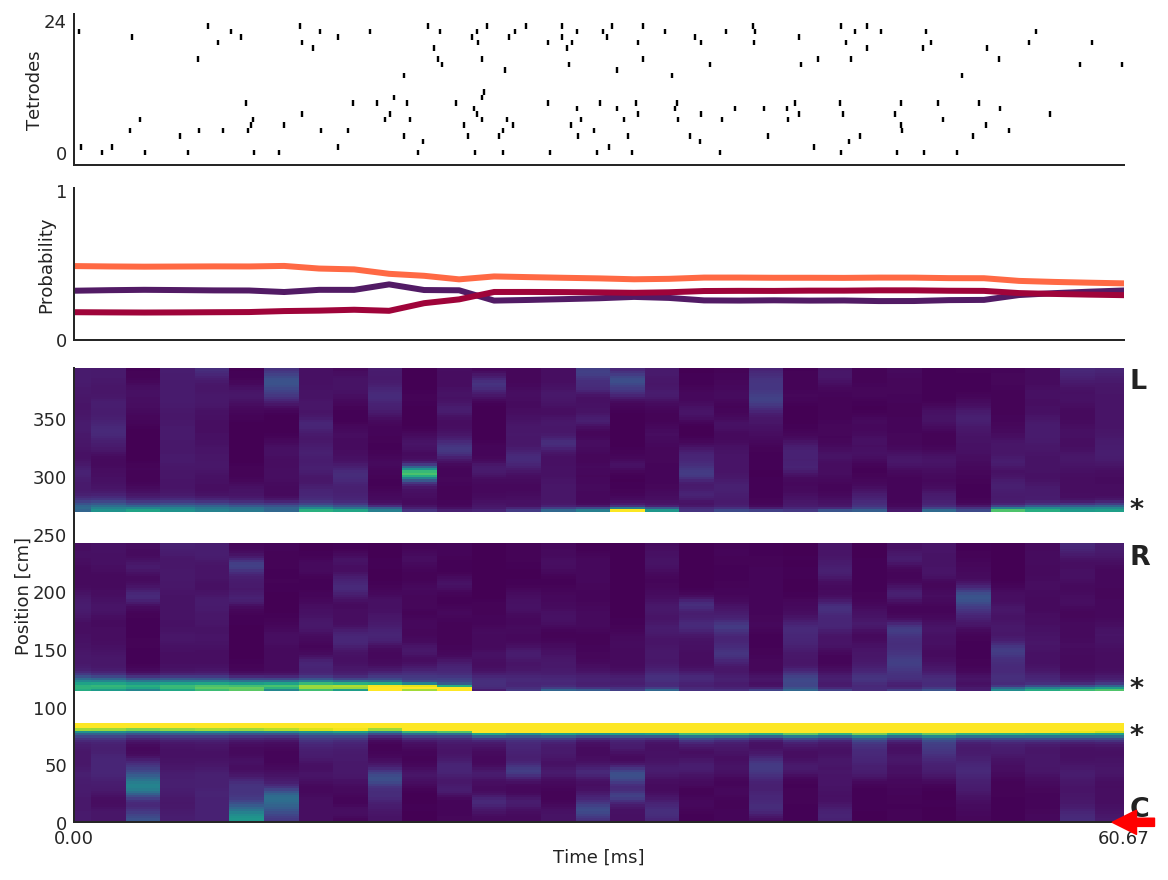

In [14]:
epoch_key = 'remy', 36, 2
ripple_number = 142

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-02.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-03.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-04.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-06.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-07.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks36-09.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-D

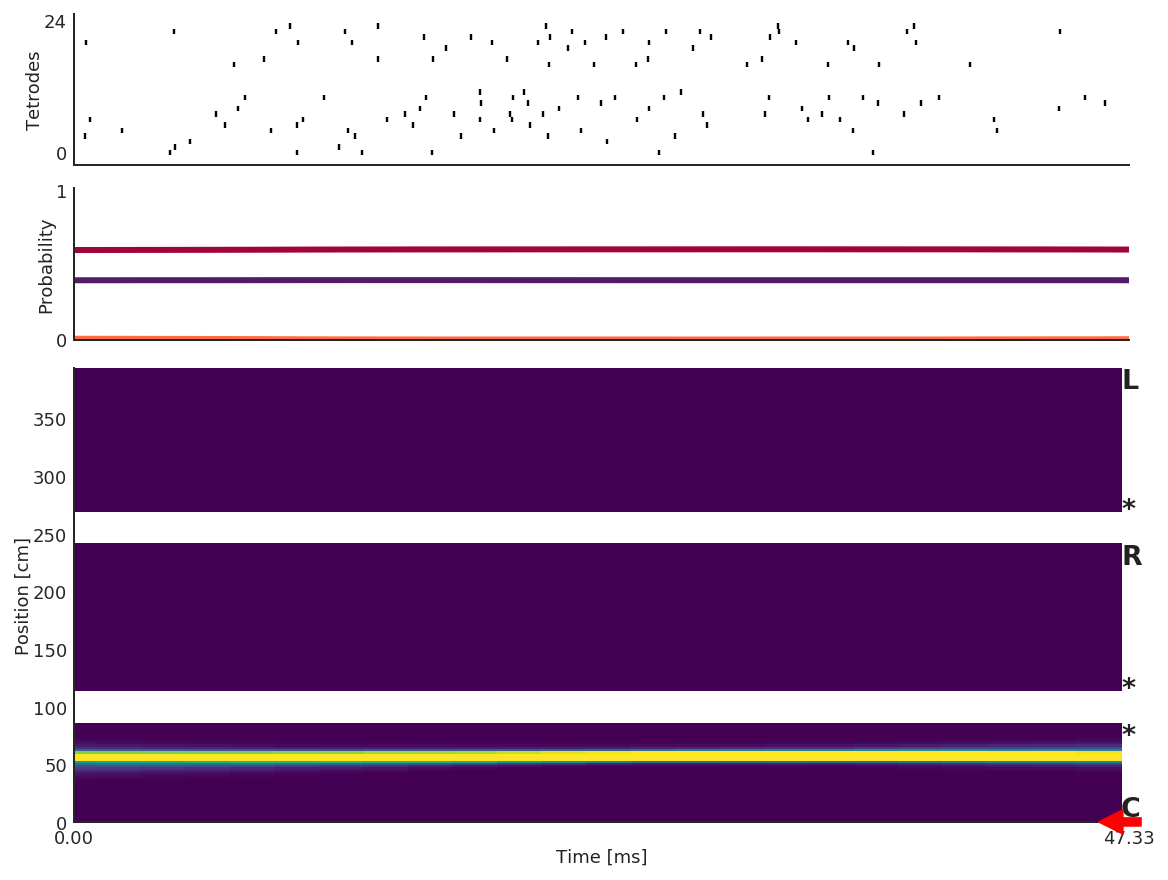

In [15]:
epoch_key = 'remy', 36, 2
ripple_number = 151

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-02.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-03.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-04.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-06.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-07.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/EEG/remymarks35-09.mat
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-D

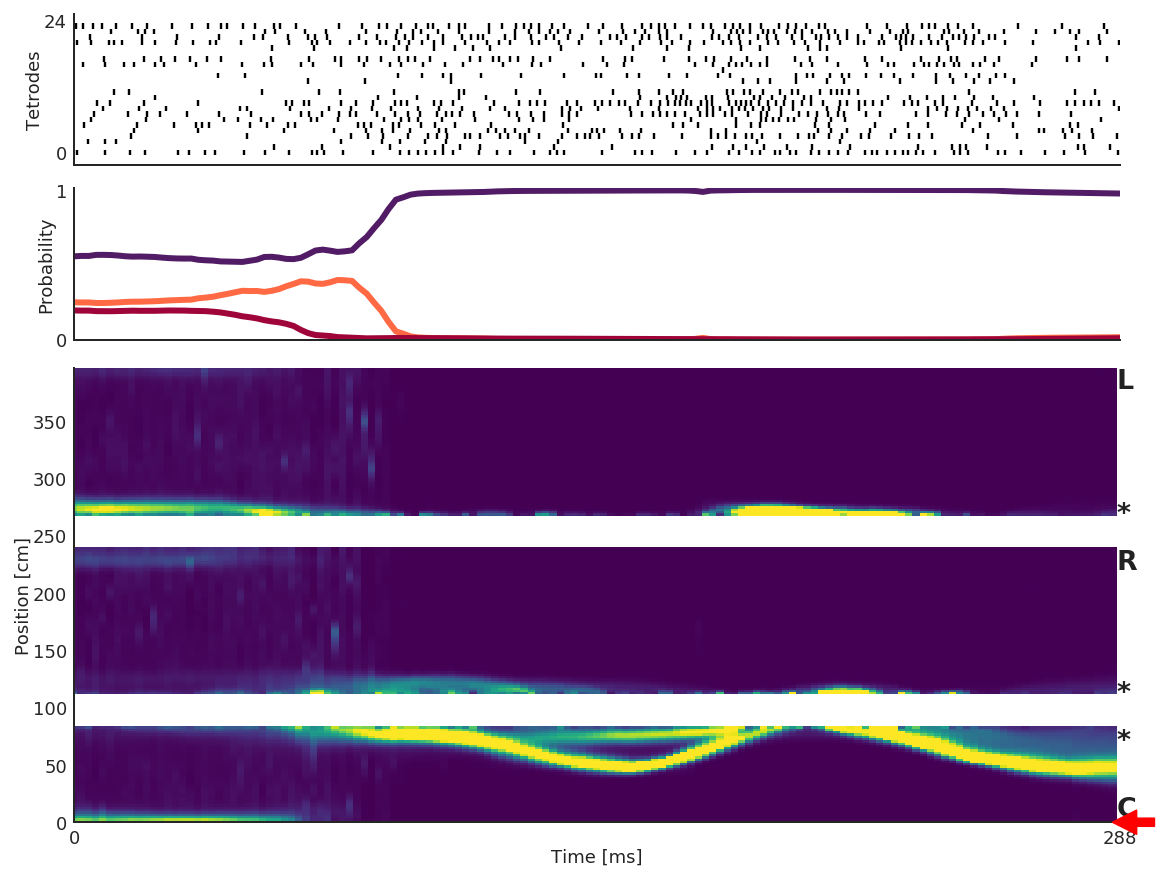

In [16]:
epoch_key = 'remy', 35, 4
ripple_number = 267

plot_ripple_figure_1D(epoch_key, ripple_number)

## Summary

In [3]:
from glob import glob
import os
import pandas as pd
from src.parameters import PROCESSED_DATA_DIR, STATE_COLORS, STATE_ORDER
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_linear_position_markers,
)

data_type, dim = "clusterless", "1D"
n_unique_spiking = 2

file_paths = glob(
    os.path.join(PROCESSED_DATA_DIR, f"*_{data_type}_{dim}_replay_info.csv")
)
replay_info = pd.concat(
    [pd.read_csv(file_path) for file_path in file_paths], axis=0
).set_index(["animal", "day", "epoch", "ripple_number"])
replay_info = replay_info.loc[
    replay_info.n_unique_spiking >= n_unique_spiking
].sort_index()

In [4]:
replay_info.head()

actual_linear_distance  \
animal day epoch ripple_number                           
Cor    1   2     1                           24.465043   
                 2                           63.782914   
                 3                            3.531813   
                 4                            0.000000   
                 5                            0.000000   

                                actual_linear_position2  actual_speed  \
animal day epoch ripple_number                                          
Cor    1   2     1                            24.465043      3.521354   
                 2                            63.782914      1.419764   
                 3                             3.531813      0.669475   
                 4                             0.000000      0.001782   
                 5                             0.000000      0.047498   

                                actual_velocity_center_well  \
animal day epoch ripple_number                                
Cor    1   2     1                                 3.144096   
                 2                                 0.911520   
                 3                                 0.276608   
                 4                                 0.000000   
                 5                                 0.000000   

                                actual_x_position  actual_y_position  \
animal day epoch ripple_number                                         
Cor    1   2     1                     279.998776         169.545937   
                 2                     289.695835         130.587756   
                 3                     270.042708         190.324914   
                 4                     279.300000         198.360000   
                 5                     279.300000         198.360000   

                                center_well_position  choice_position  \
animal day epoch ripple_number                                          
Cor    1   2     1                               0.0        76.762539   
                 2                               0.0        76.762539   
                 3                               0.0        76.762539   
                 4                               0.0        76.762539   
                 5                               0.0        76.762539   

                                continuous  continuous_duration  ...  \
animal day epoch ripple_number                                   ...   
Cor    1   2     1                   False                0.000  ...   
                 2                   False                0.000  ...   
                 3                   False                0.000  ...   
                 4                    True                0.074  ...   
                 5                   False                0.000  ...   

                                replay_distance_from_center_well  \
animal day epoch ripple_number                                     
Cor    1   2     1                                     16.993550   
                 2                                     67.929333   
                 3                                     15.622694   
                 4                                     35.351494   
                 5                                      1.596961   

                                replay_linear_position  replay_speed  \
animal day epoch ripple_number                                         
Cor    1   2     1                           16.972256      0.000018   
                 2                           66.890656      0.000010   
                 3                           12.978784      0.000002   
                 4                           46.605634      0.008170   
                 5                            0.998368      0.000000   

                                replay_total_displacement  \
animal day epoch ripple_number                              
Cor    1   2     1                           

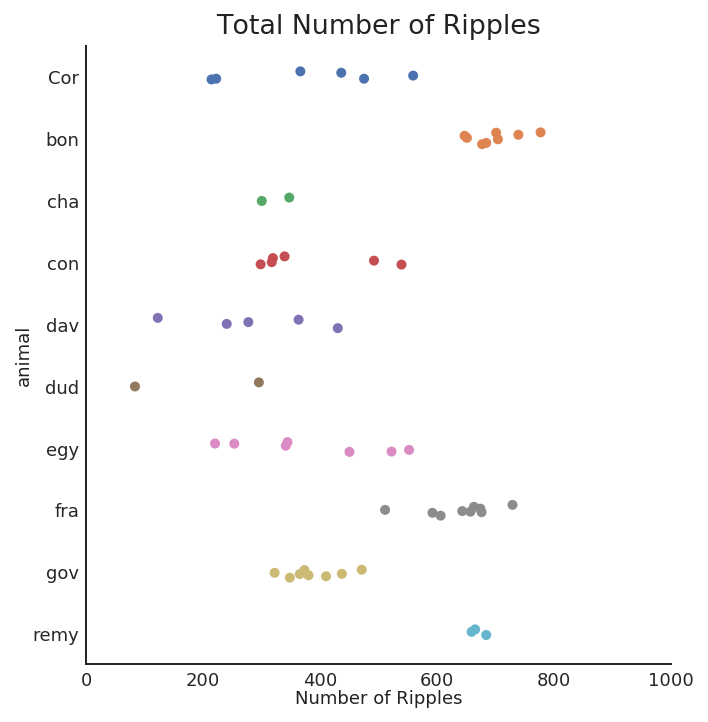

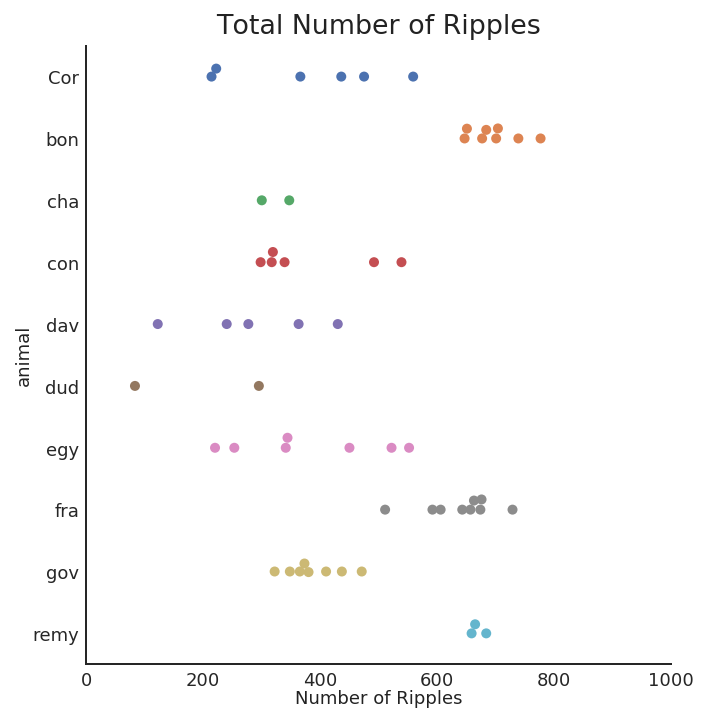

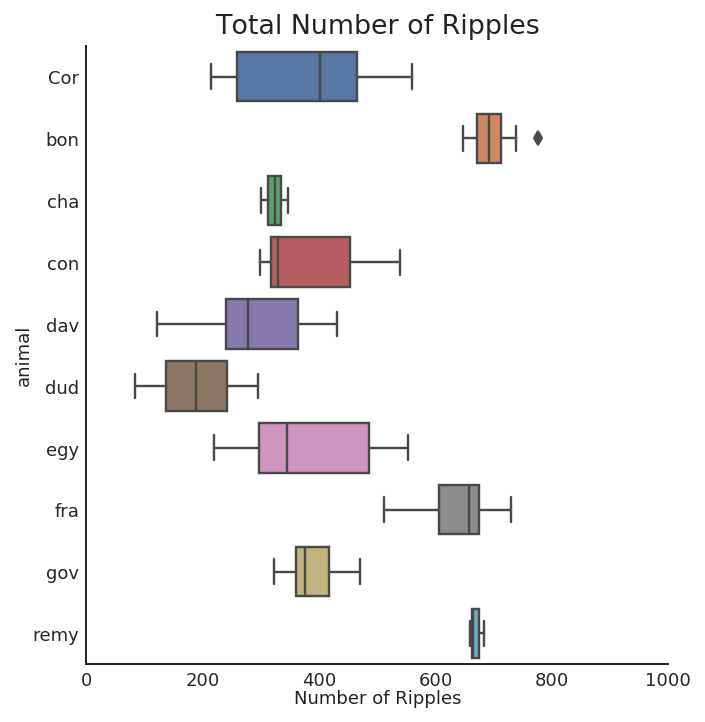

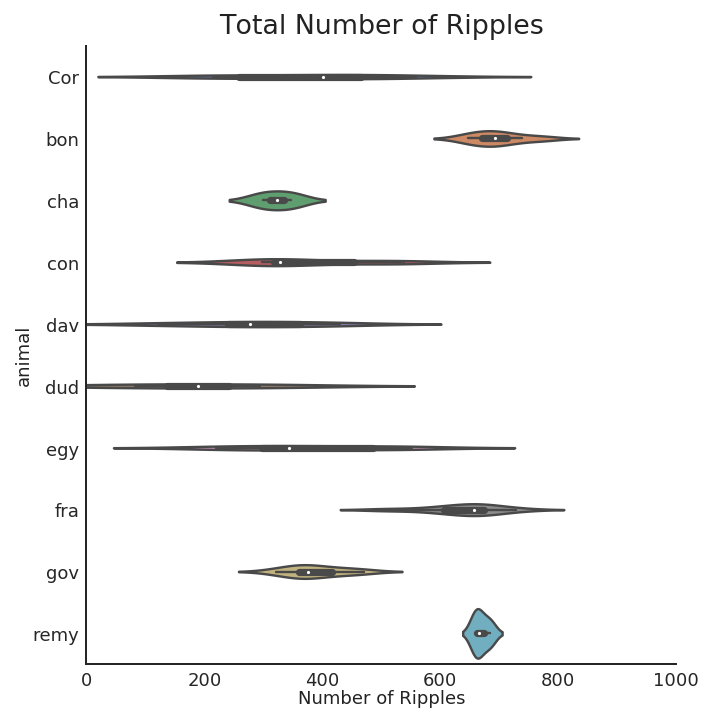

In [5]:
import seaborn as sns

n_ripples_by_day = (
    replay_info.groupby(["animal", "day"])
    .is_classified.size()
    .rename("Number of Ripples")
)

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=n_ripples_by_day.reset_index(),
        x="Number of Ripples",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 1000))
    plt.title("Total Number of Ripples")

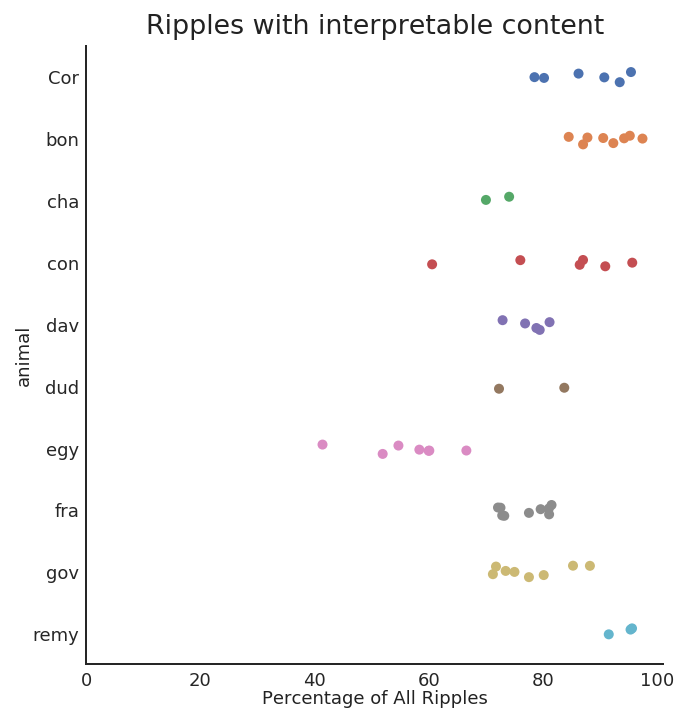

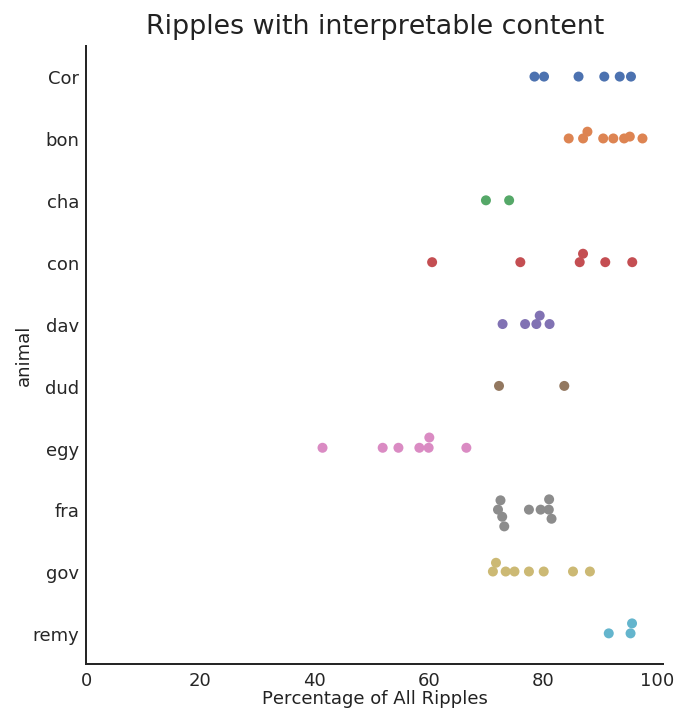

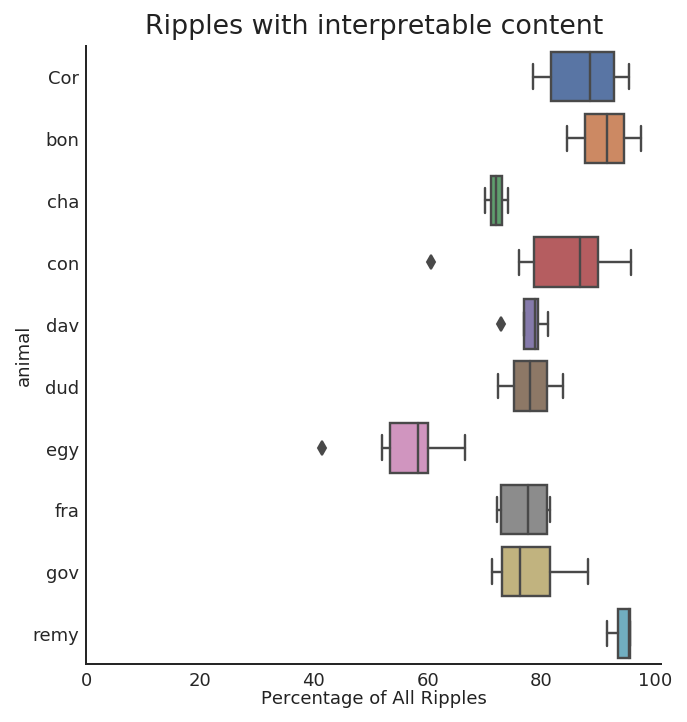

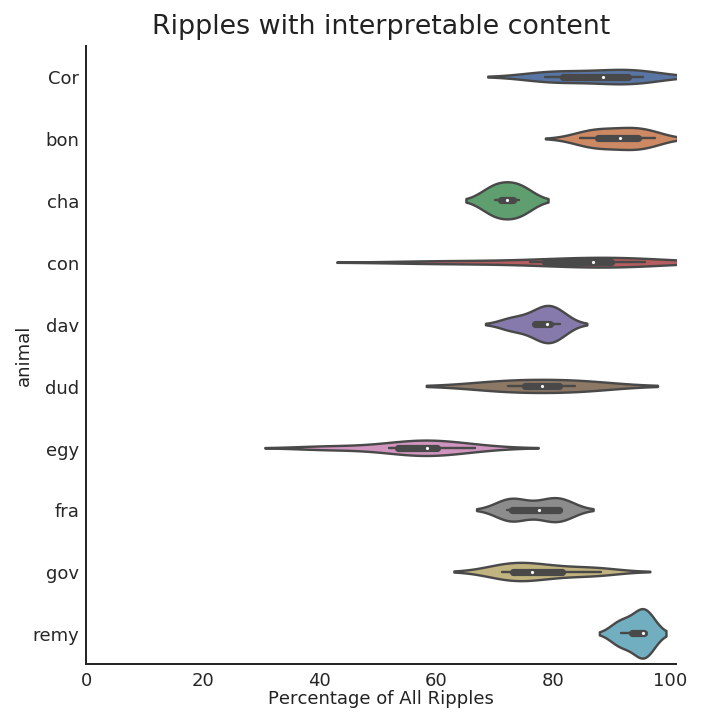

In [172]:
df = (
    replay_info.groupby(["animal", "day"])
    .apply(lambda df: (df["is_classified"]).mean() * 100)
    .rename("Percentage of All Ripples")
)

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of All Ripples",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 101))
    plt.title("Ripples with interpretable content")

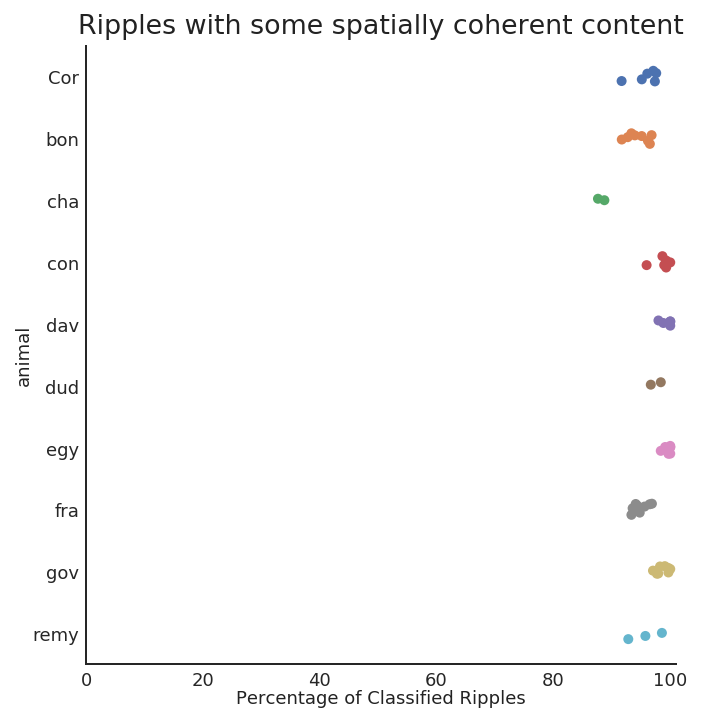

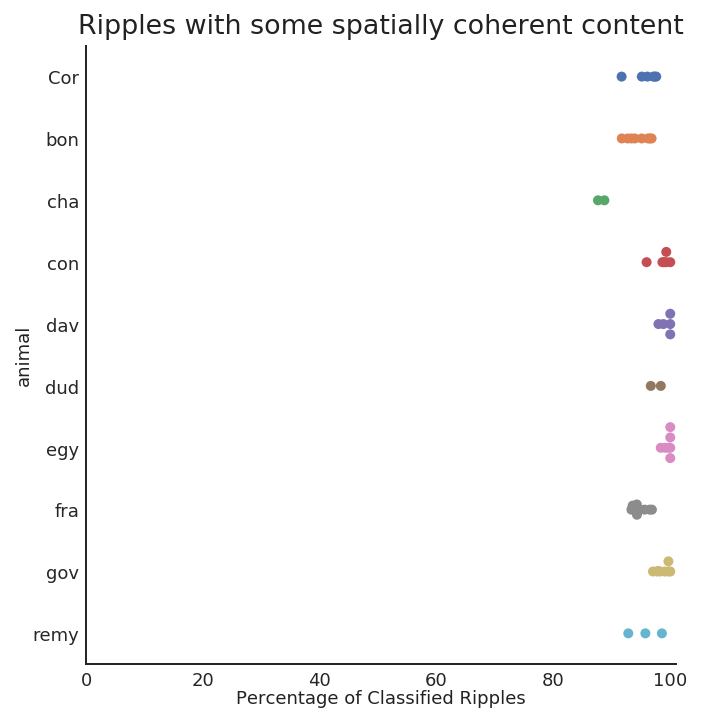

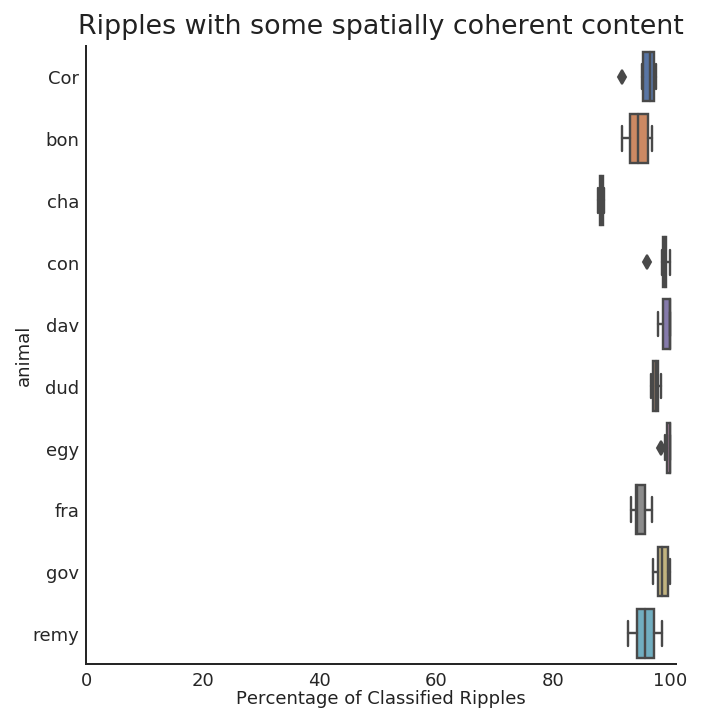

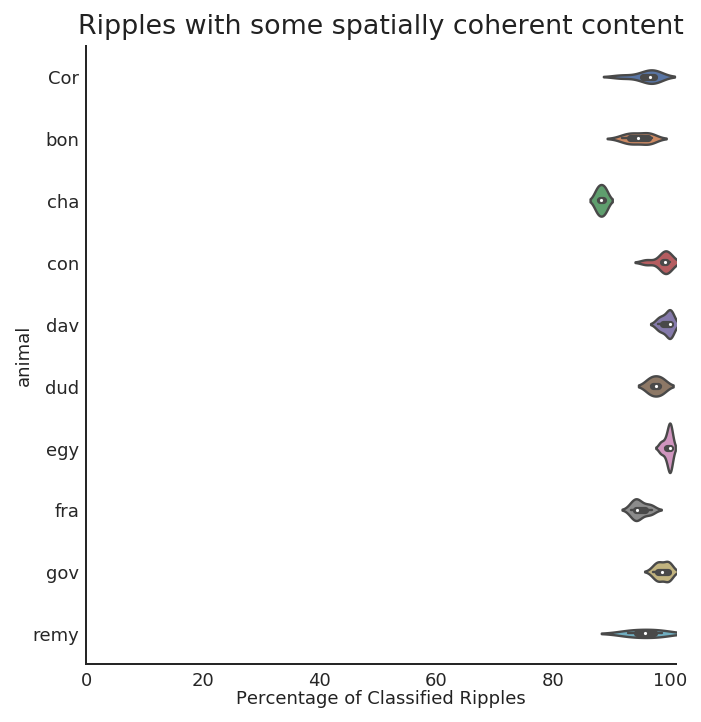

In [7]:
df = (
    replay_info.loc[replay_info.is_classified]
    .groupby(["animal", "day"])
    .apply(
        lambda df: (df["hover"] | df["hover-continuous-mix"] | df["continuous"]).mean()
        * 100
    )
    .rename("Percentage of Classified Ripples")
)
for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 101))
    plt.title("Ripples with some spatially coherent content")

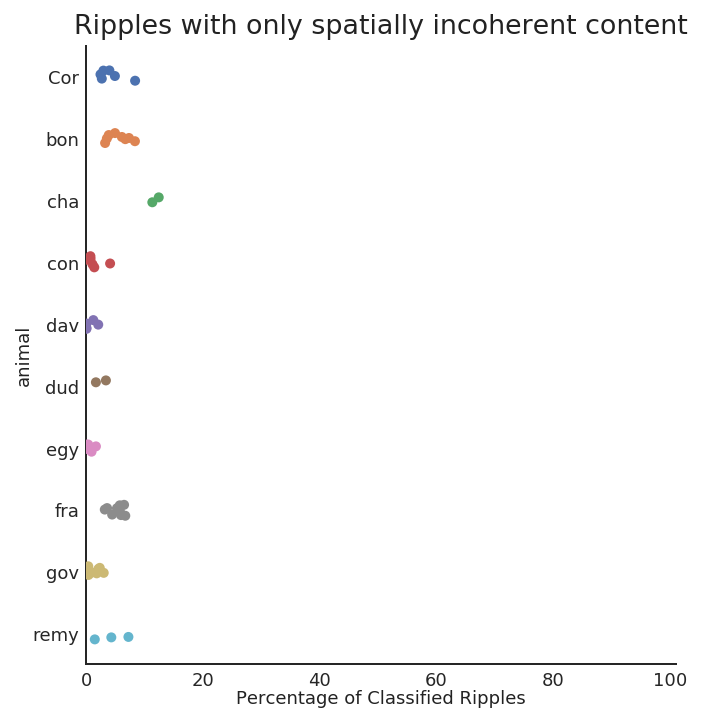

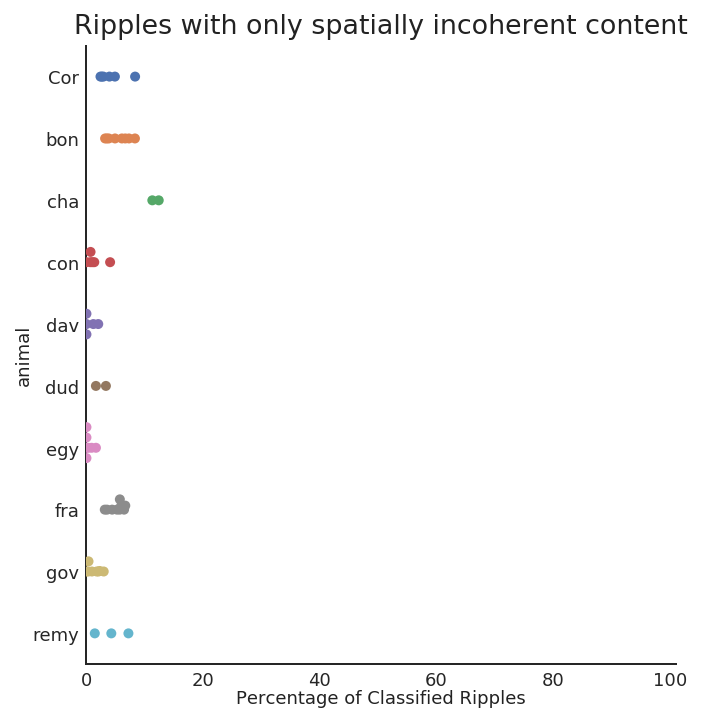

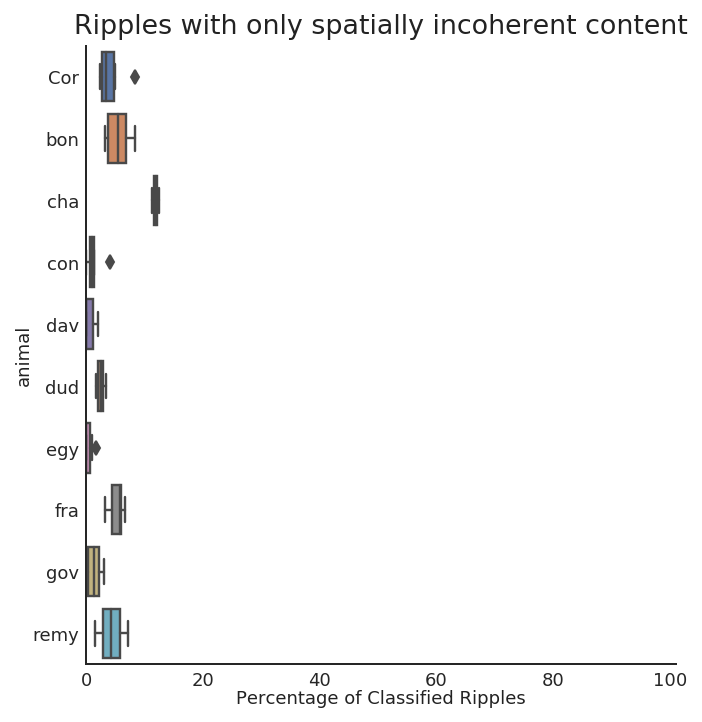

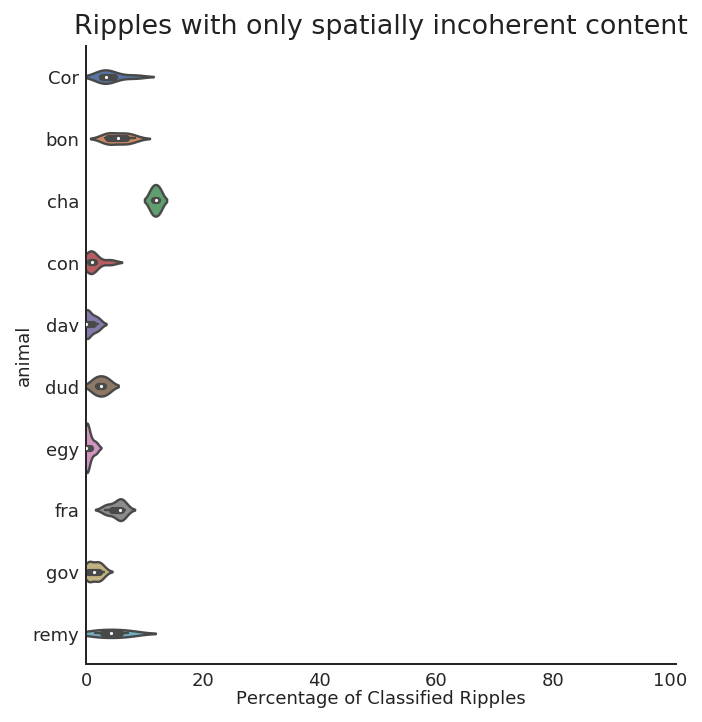

In [6]:
df = (
    replay_info.loc[replay_info.is_classified]
    .groupby(["animal", "day"])
    .apply(
        lambda df: (
            (df["fragmented-continuous-mix"] | df["fragmented"])
            & ~(df["hover"] | df["hover-continuous-mix"] | df["continuous"])
        ).mean()
        * 100
    )
    .rename("Percentage of Classified Ripples")
)

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 101))
    plt.title("Ripples with only spatially incoherent content")

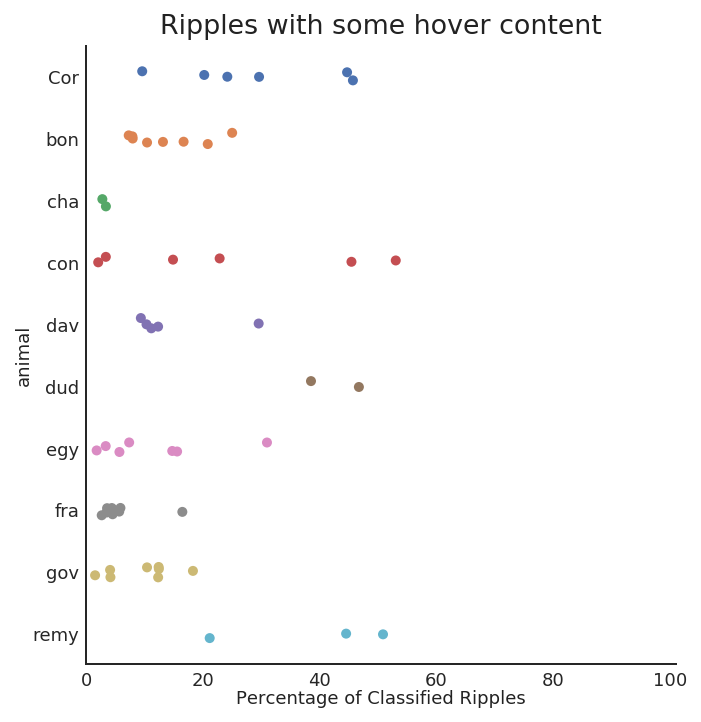

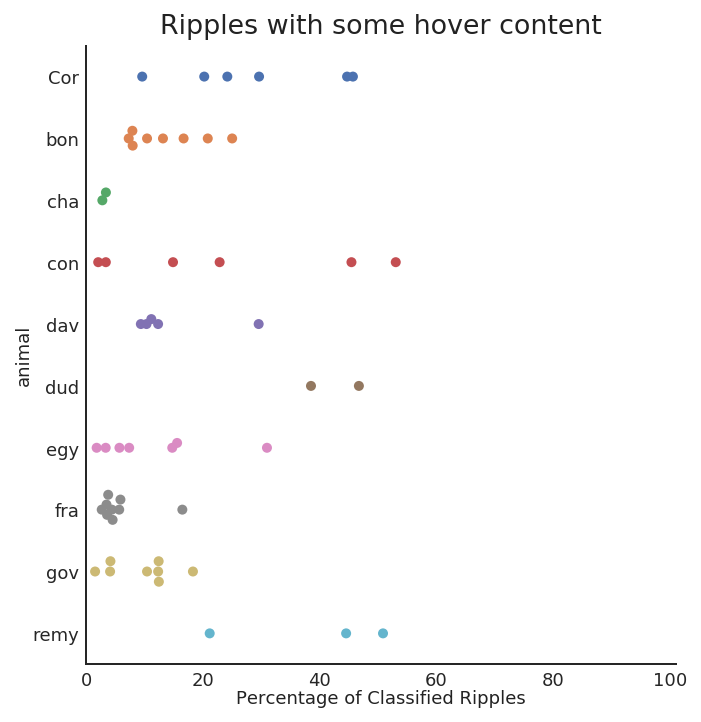

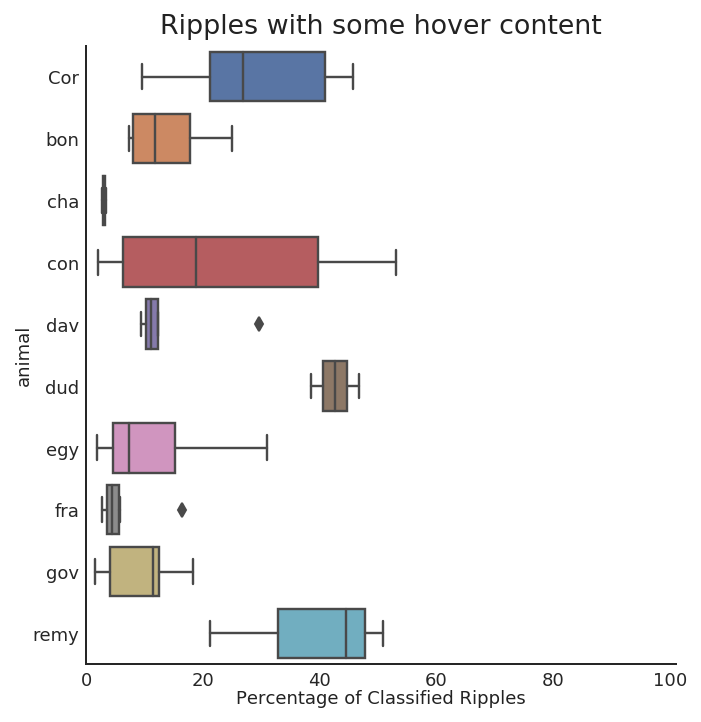

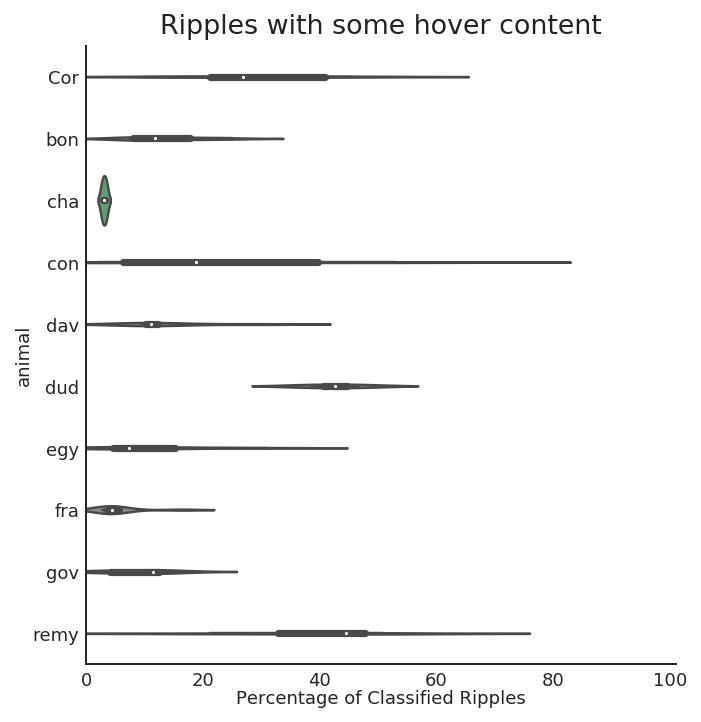

In [174]:
df = (
    replay_info.loc[replay_info.is_classified]
    .groupby(["animal", "day"])
    .apply(lambda df: (df["hover"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 101))
    plt.title("Ripples with some hover content")

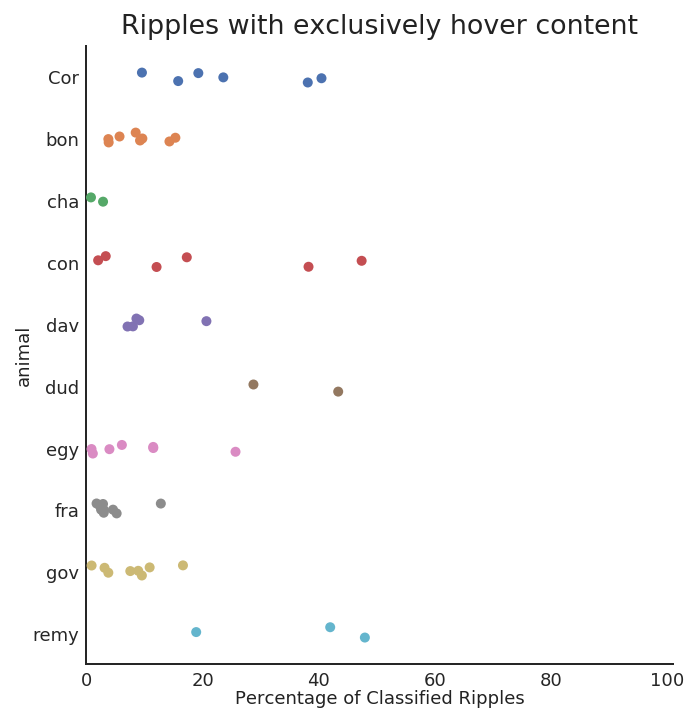

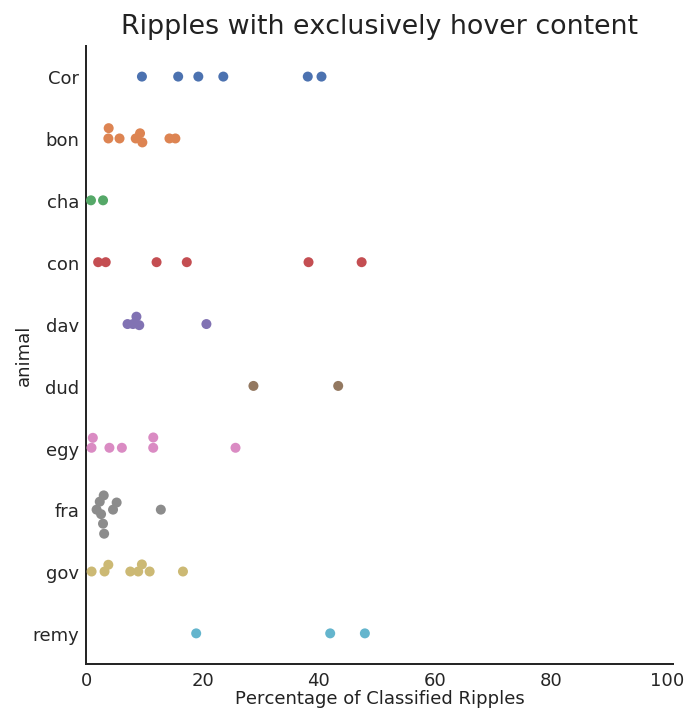

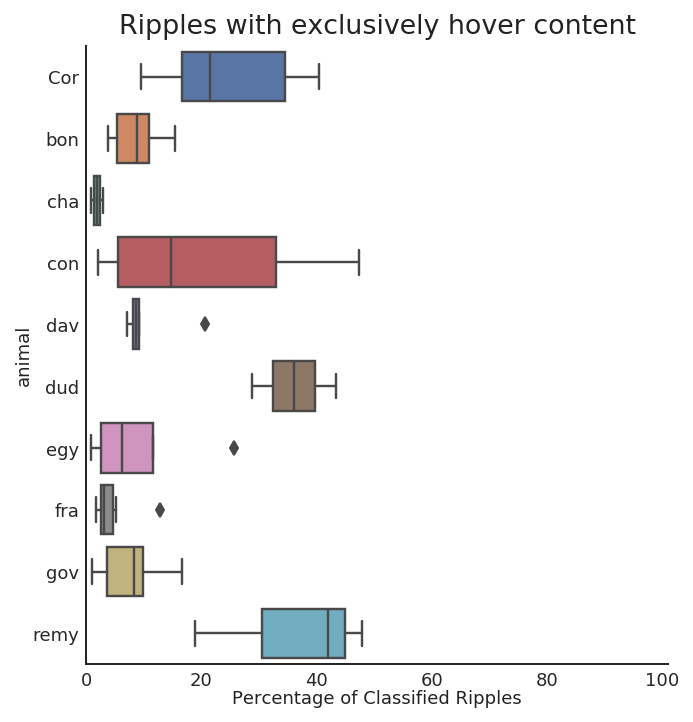

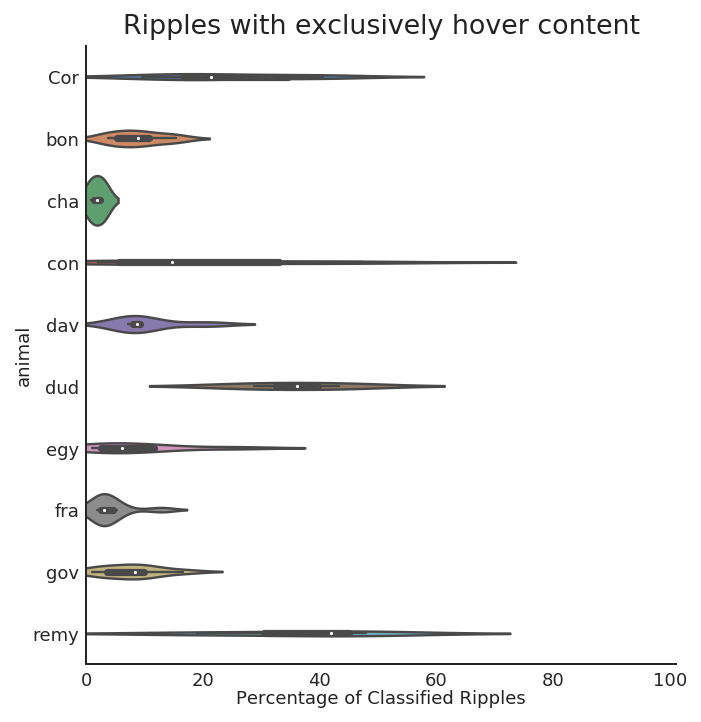

In [182]:
df = (
    replay_info.loc[replay_info.is_classified]
    .groupby(["animal", "day"])
    .apply(
        lambda df: (
            df["hover"]
            & ~(
                df["hover-continuous-mix"]
                | df["continuous"]
                | df["fragmented-continuous-mix"]
                | df["fragmented"]
            )
        ).mean()
        * 100
    )
    .rename("Percentage of Classified Ripples")
)

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 101))
    plt.title("Ripples with exclusively hover content")

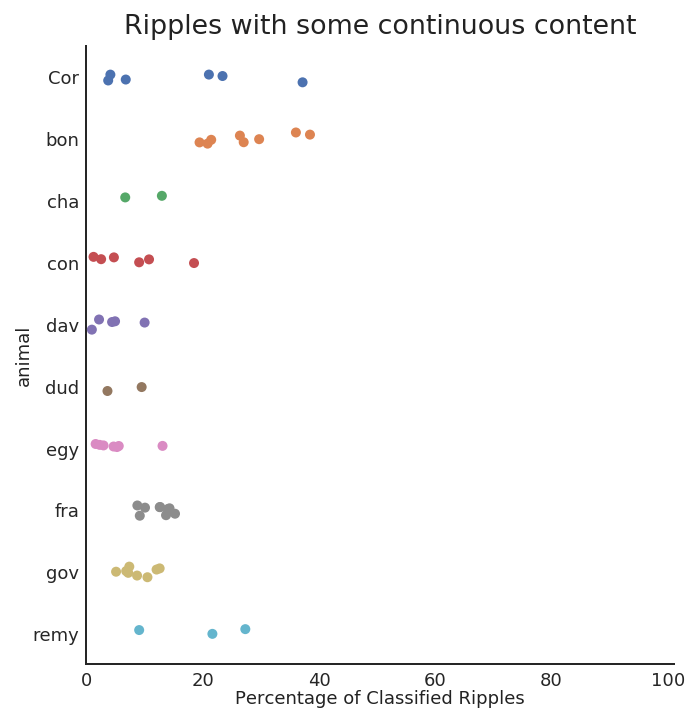

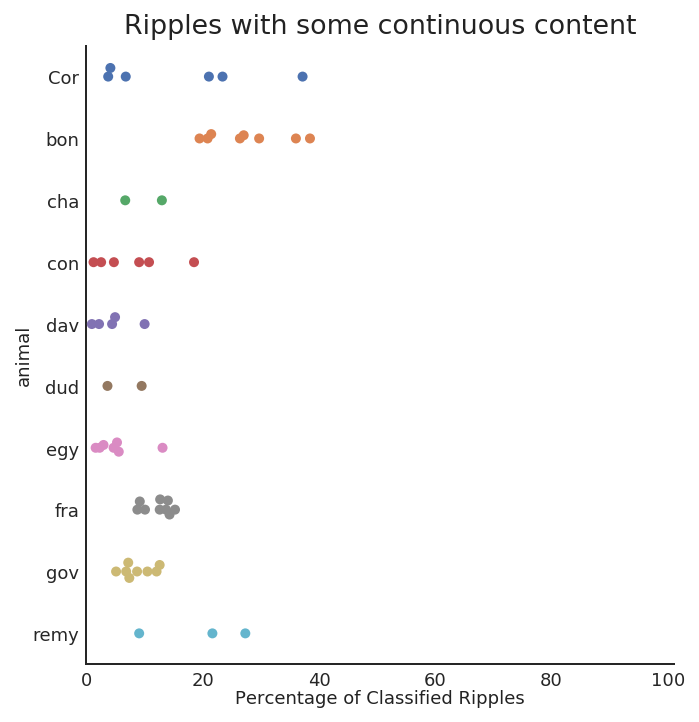

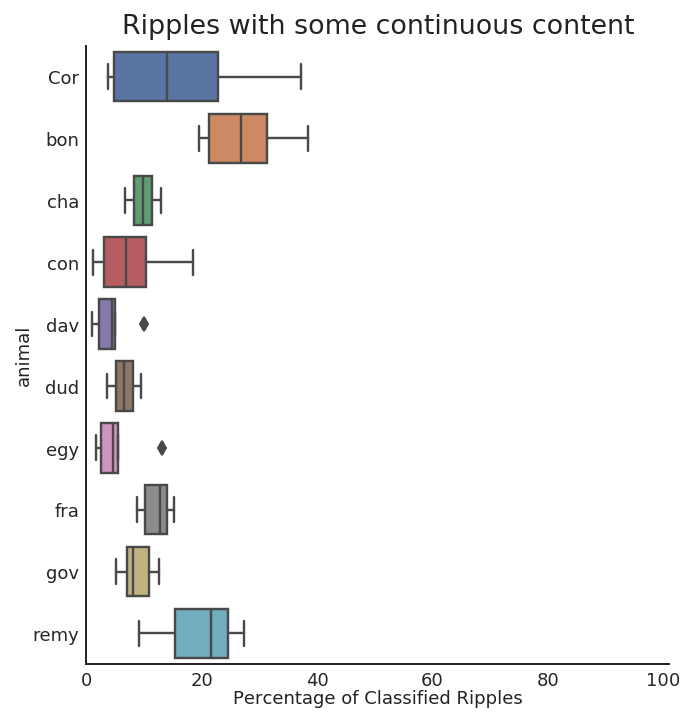

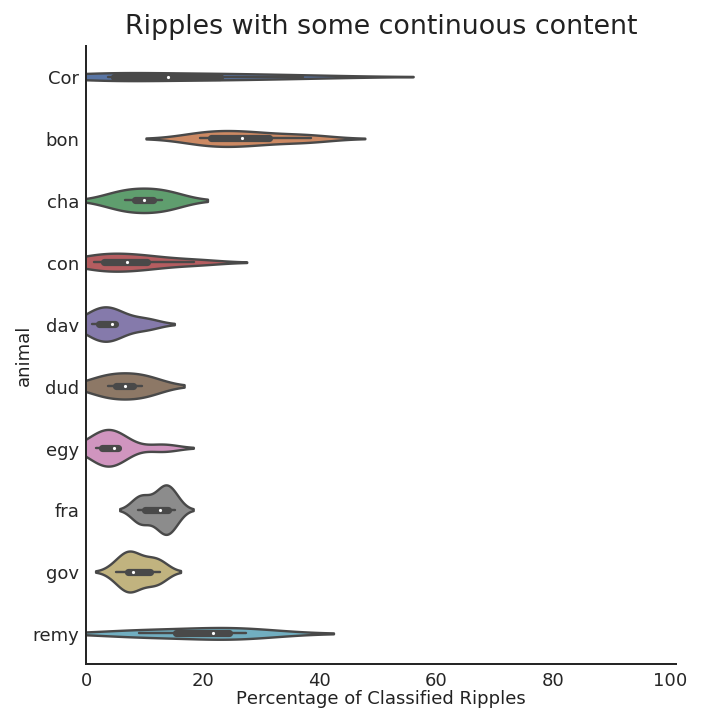

In [176]:
df = (
    replay_info.groupby(["animal", "day"])
    .apply(lambda df: (df["continuous"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 101))
    plt.title("Ripples with some continuous content")

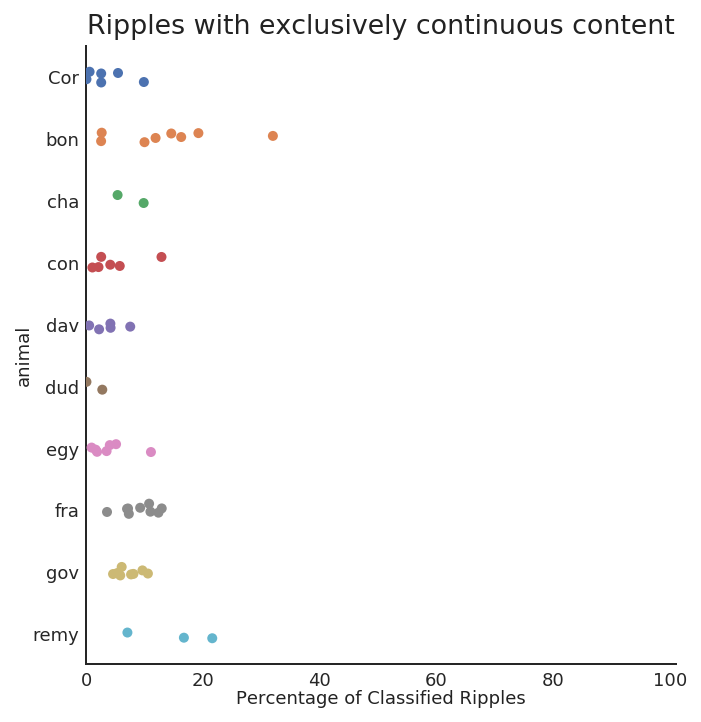

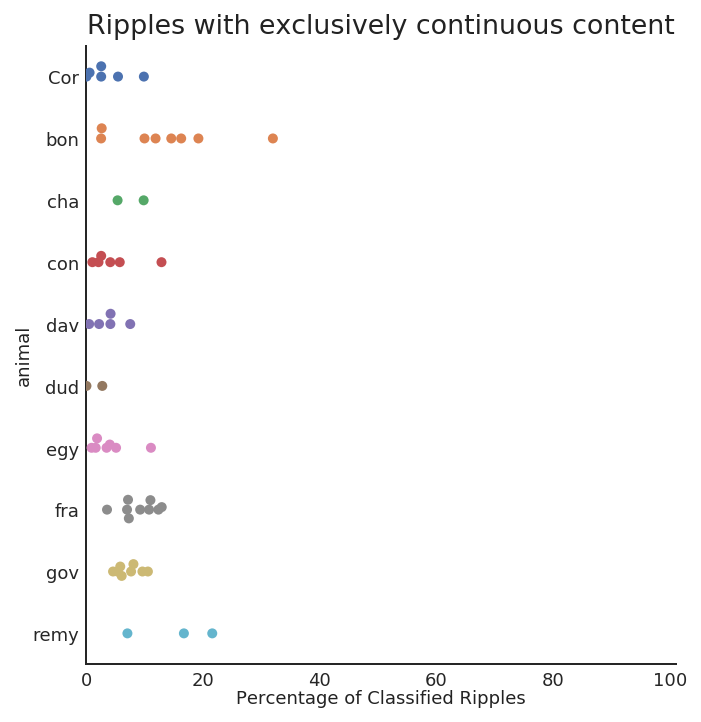

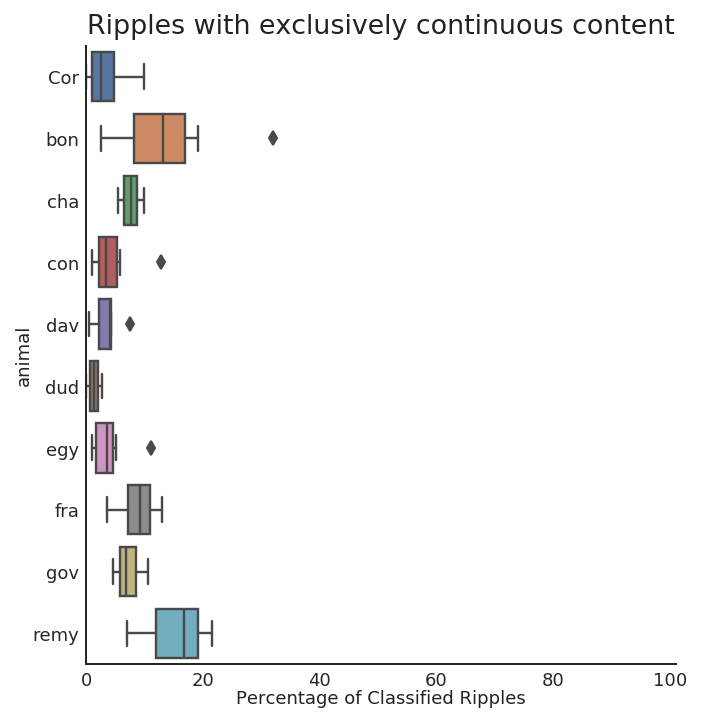

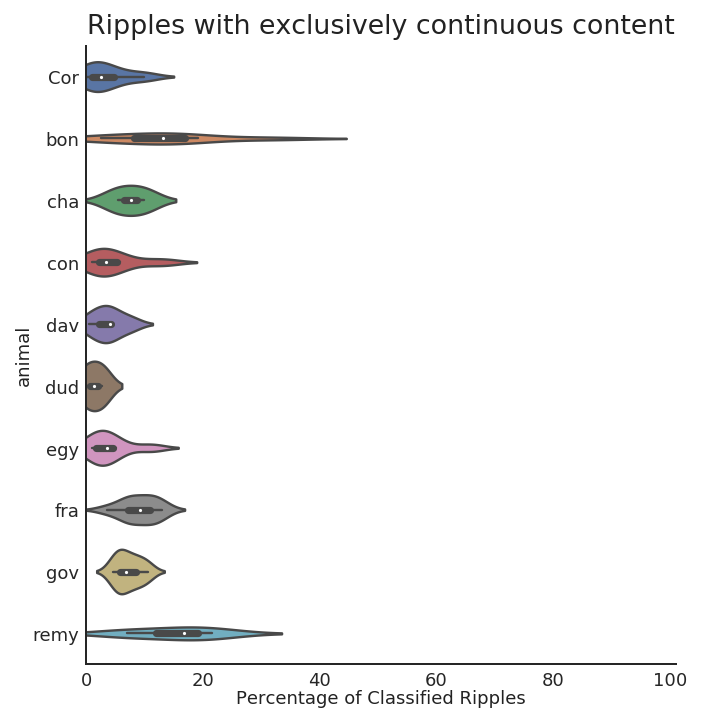

In [181]:
df = (
    replay_info.groupby(["animal", "day"])
    .apply(
        lambda df: (
            df["continuous"]
            & ~(
                df["hover"]
                | df["hover-continuous-mix"]
                | df["fragmented-continuous-mix"]
                | df["fragmented"]
            )
        ).mean()
        * 100
    )
    .rename("Percentage of Classified Ripples")
)

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 101))
    plt.title("Ripples with exclusively continuous content")

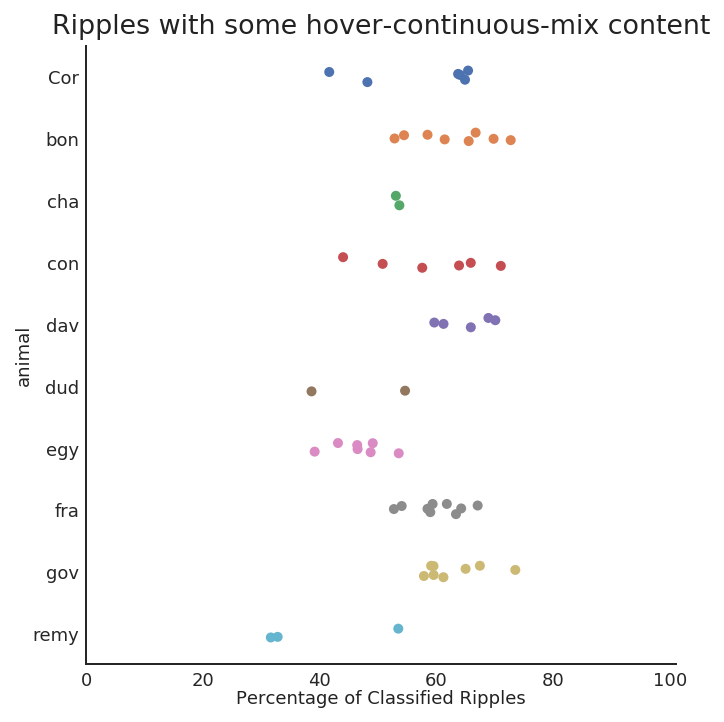

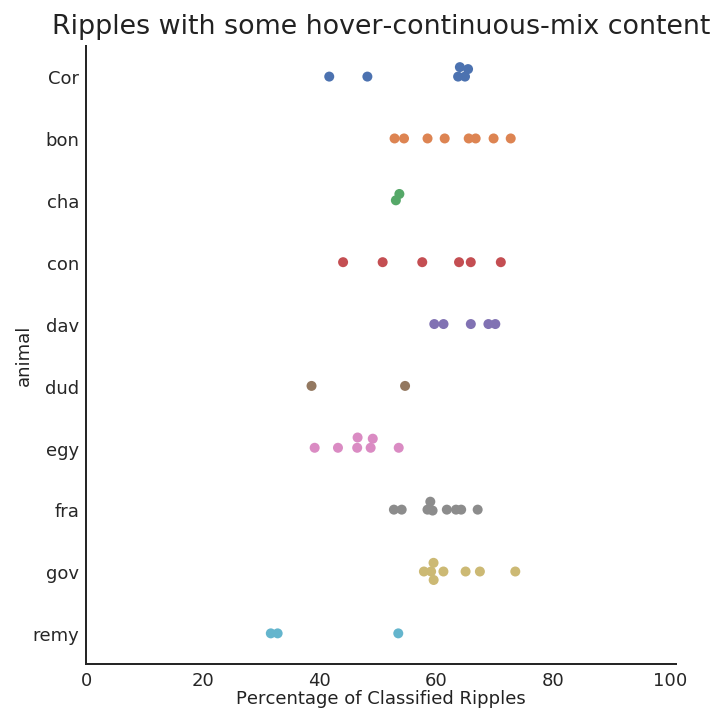

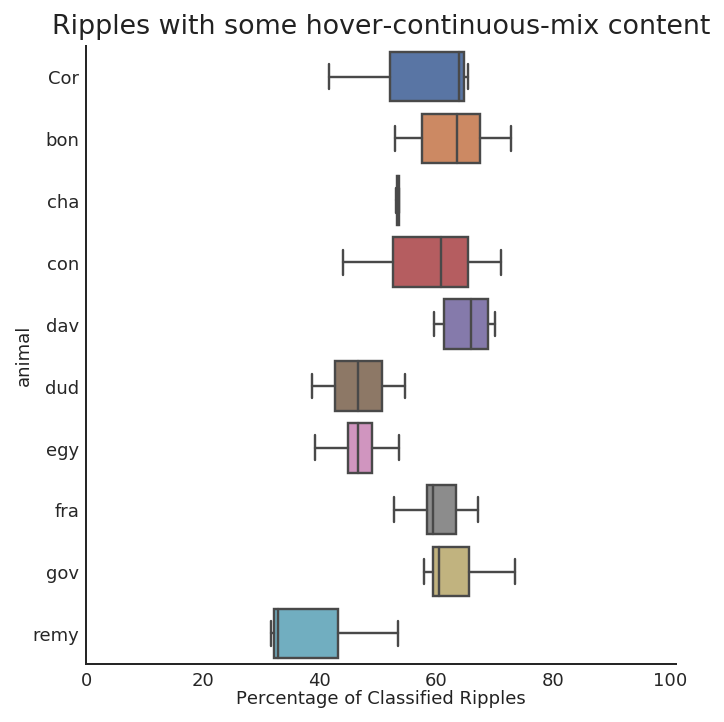

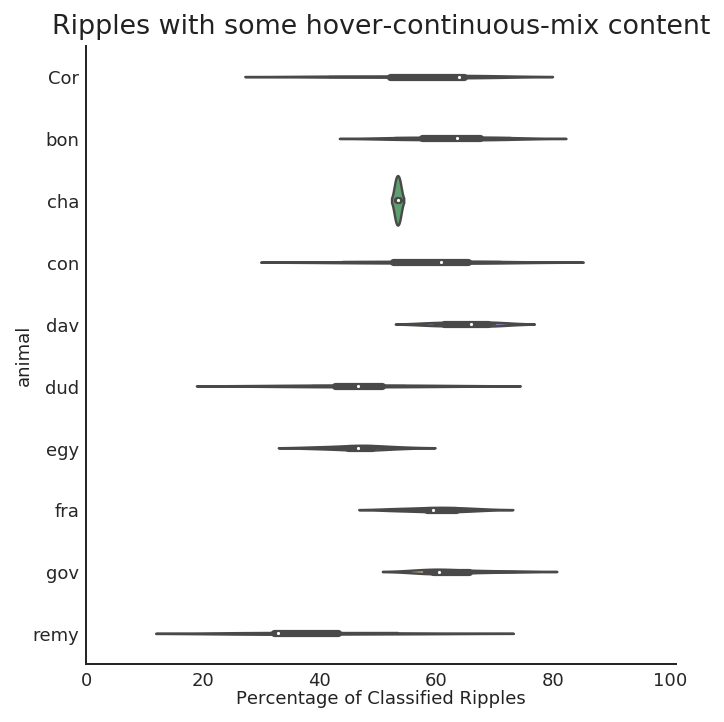

In [177]:
df = (
    replay_info.groupby(["animal", "day"])
    .apply(lambda df: (df["hover-continuous-mix"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 101))
    plt.title("Ripples with some hover-continuous-mix content")

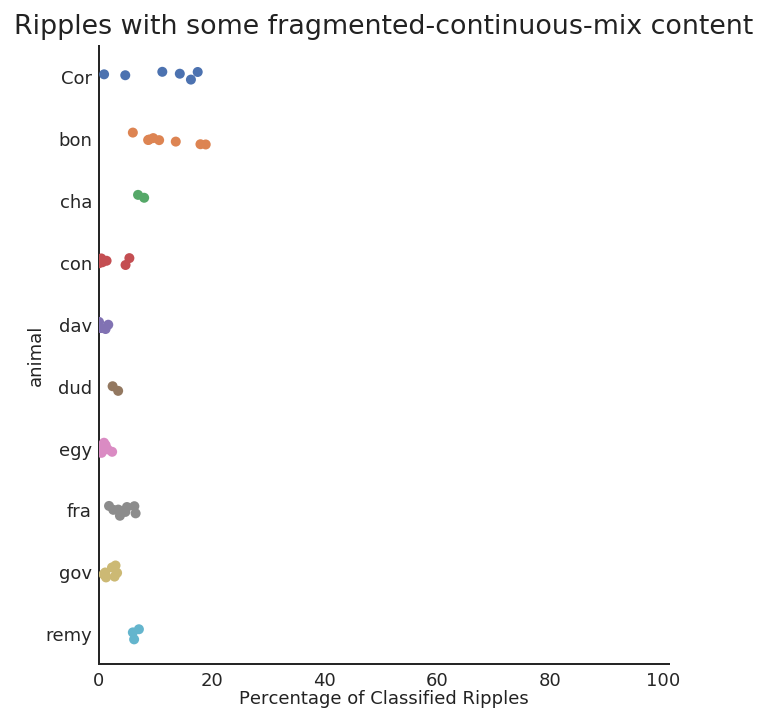

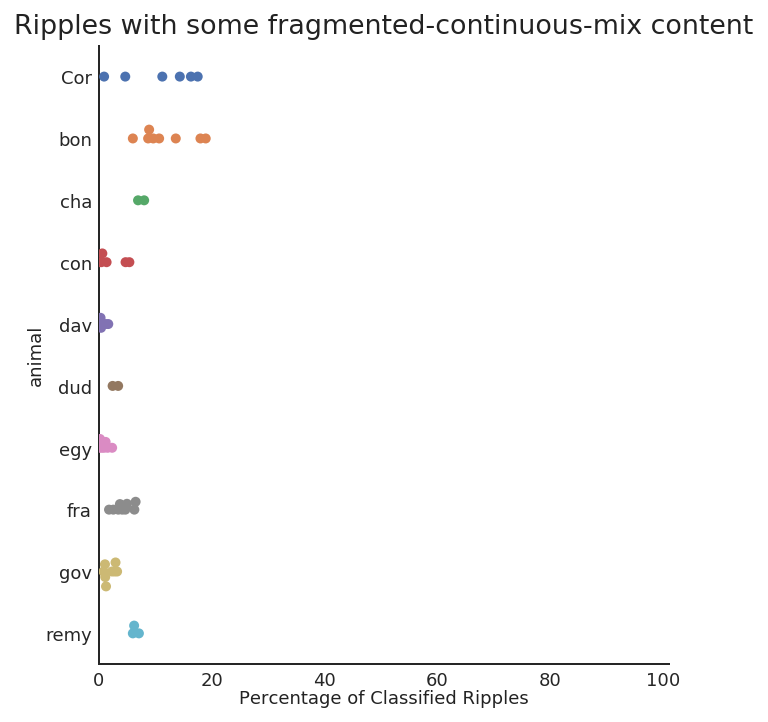

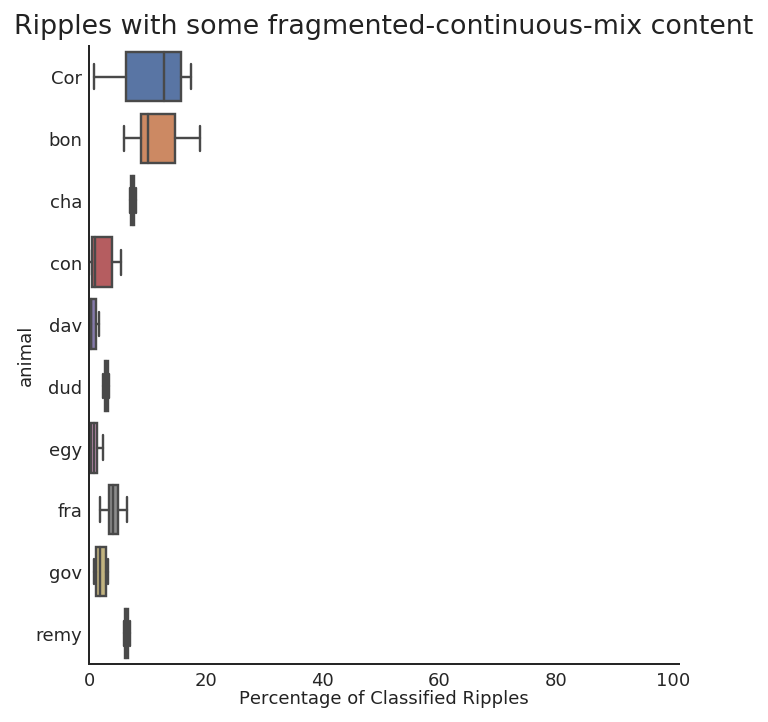

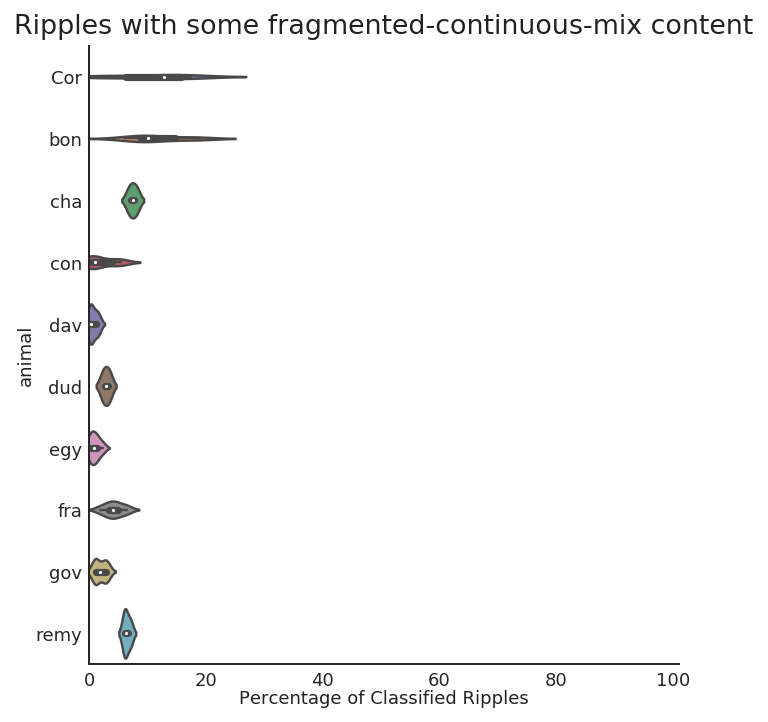

In [178]:
df = (
    replay_info.groupby(["animal", "day"])
    .apply(lambda df: (df["fragmented-continuous-mix"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 101))
    plt.title("Ripples with some fragmented-continuous-mix content")

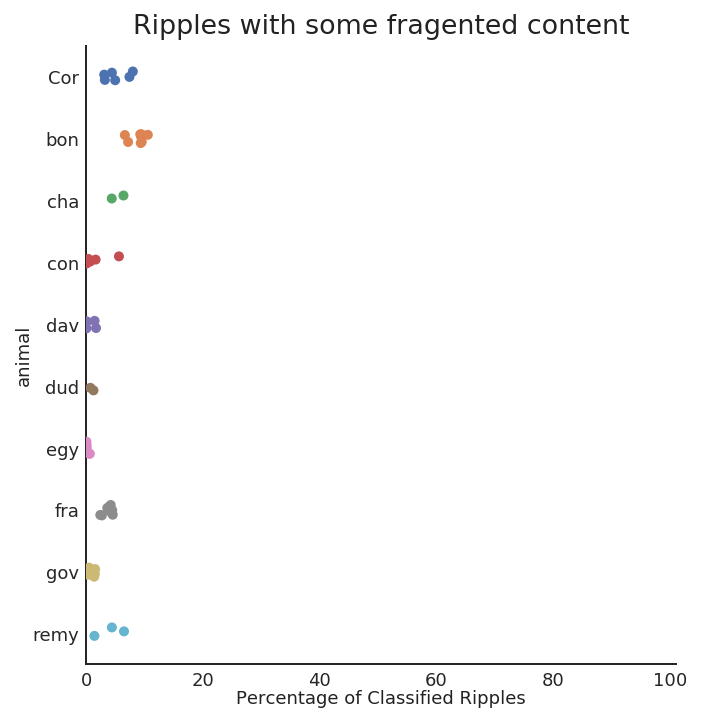

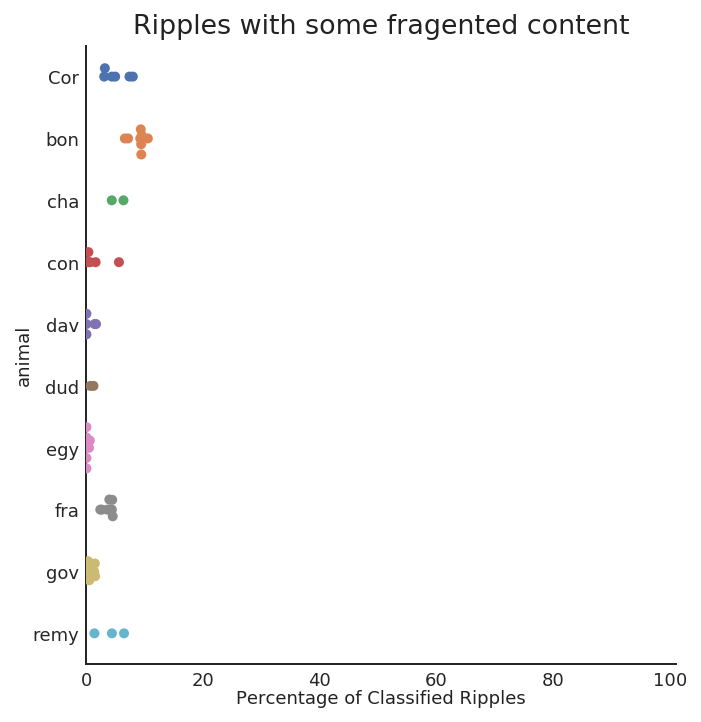

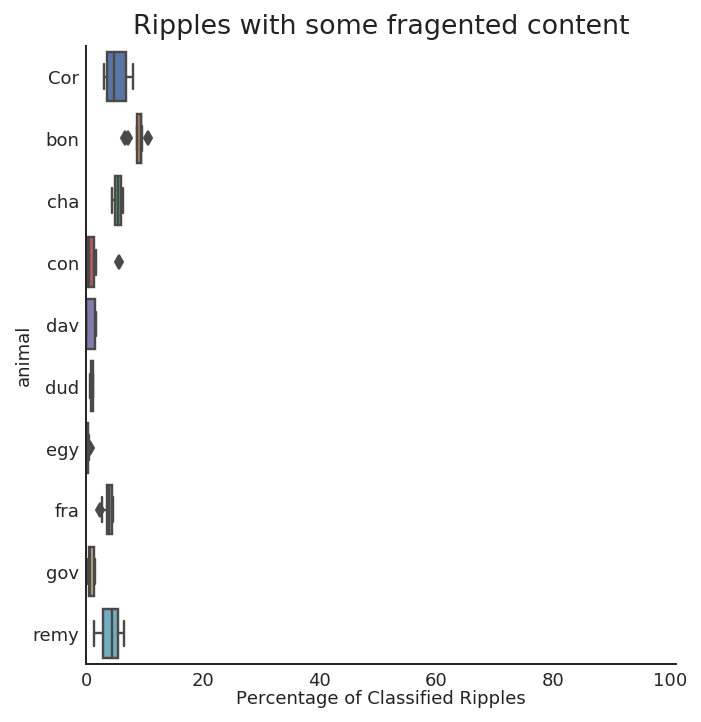

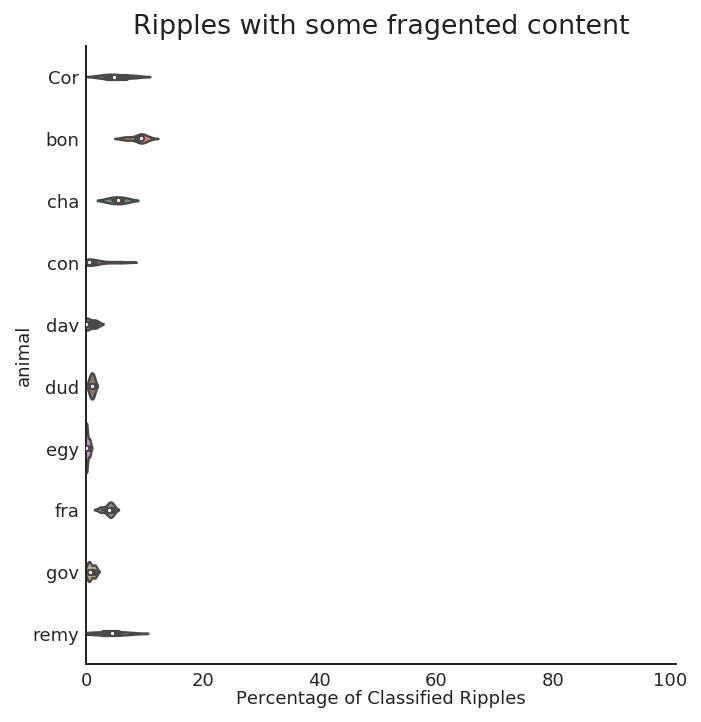

In [179]:
df = (
    replay_info.groupby(["animal", "day"])
    .apply(lambda df: (df["fragmented"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 101))
    plt.title("Ripples with some fragented content")

In [77]:
replay_info.groupby("is_classified").n_total_spikes.median()

is_classified
False    60.0
True     97.0
Name: n_total_spikes, dtype: float64

In [81]:
replay_info.groupby("is_classified").n_unique_spiking.median()

is_classified
False    10
True     12
Name: n_unique_spiking, dtype: int64

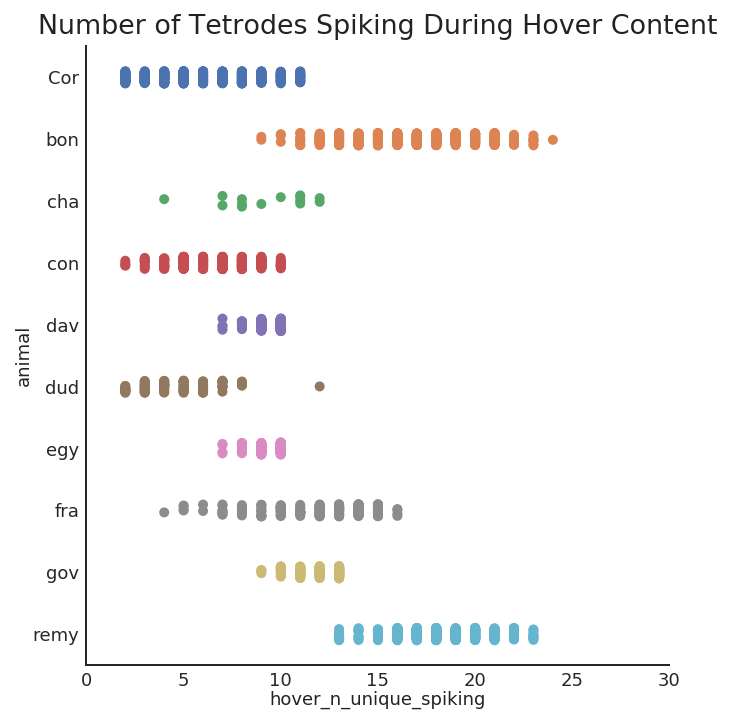

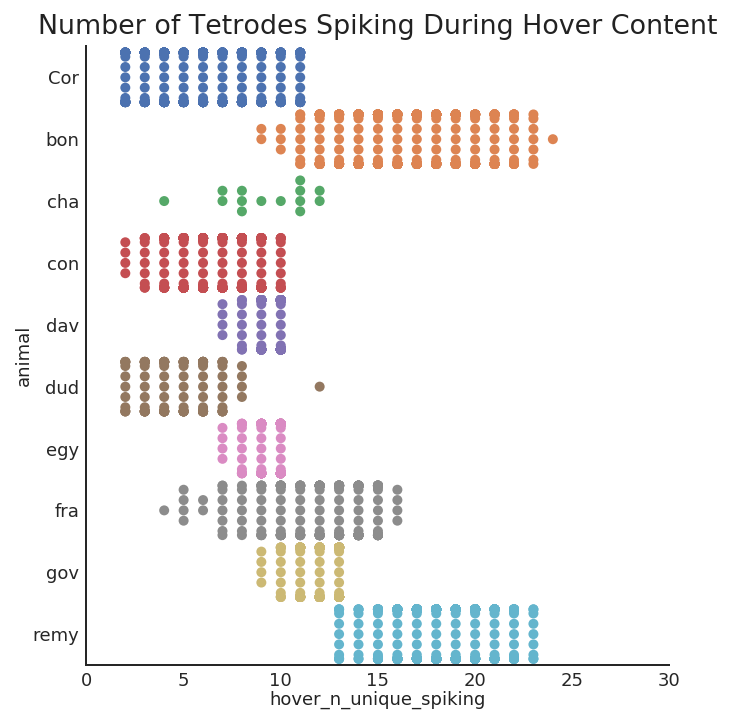

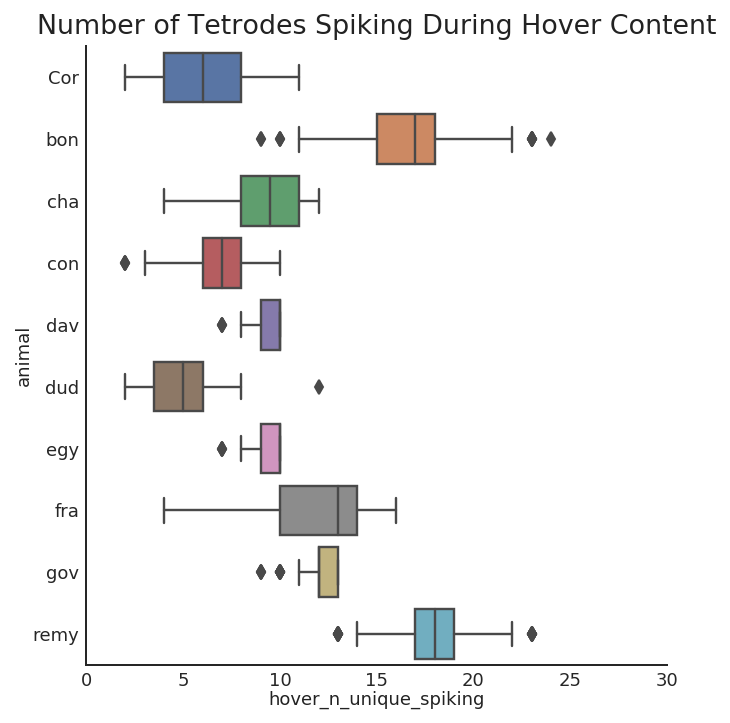

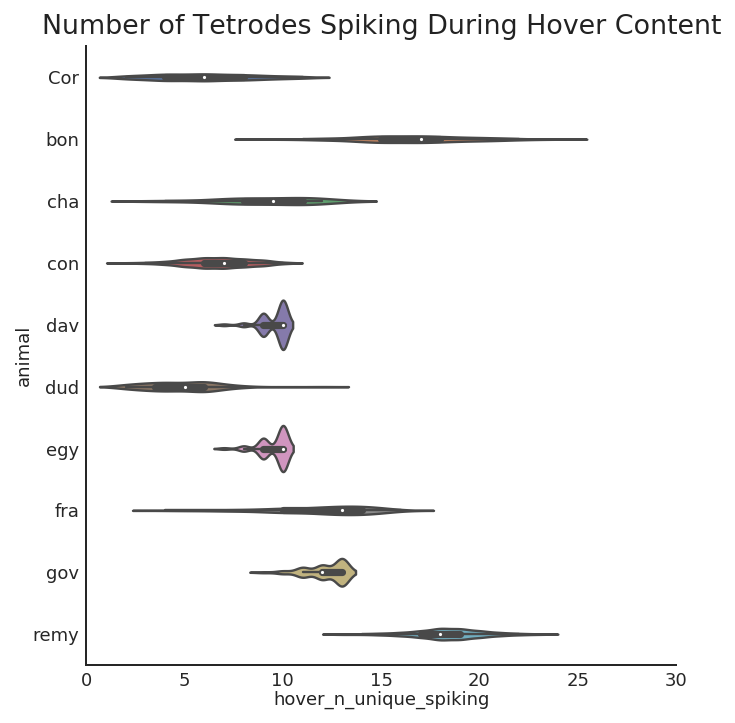

In [195]:
df = replay_info
# Need percentage of tetrodes spiking

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="hover_n_unique_spiking",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 30))
    plt.title("Number of Tetrodes Spiking During Hover Content")

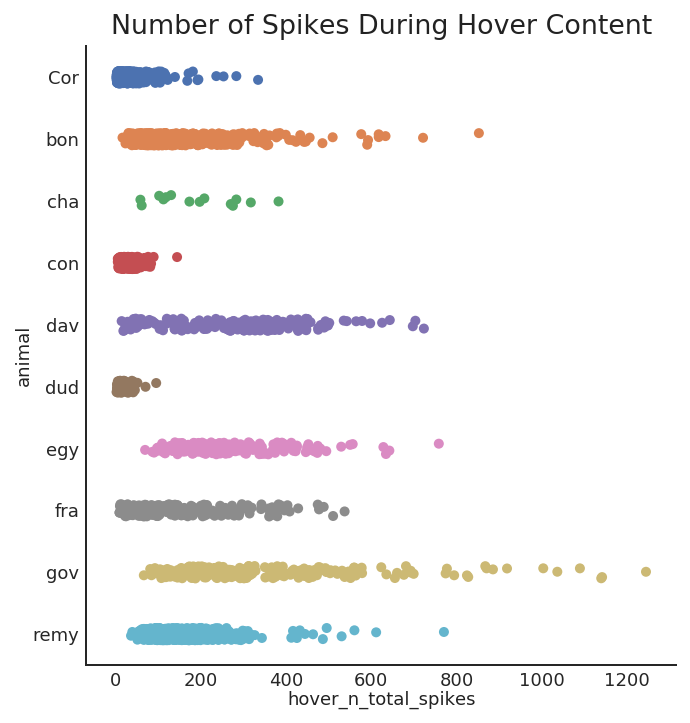

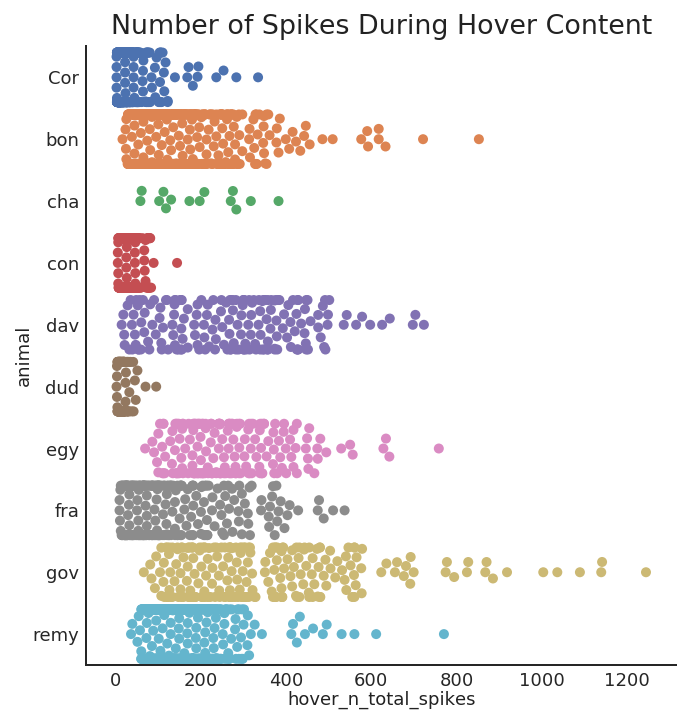

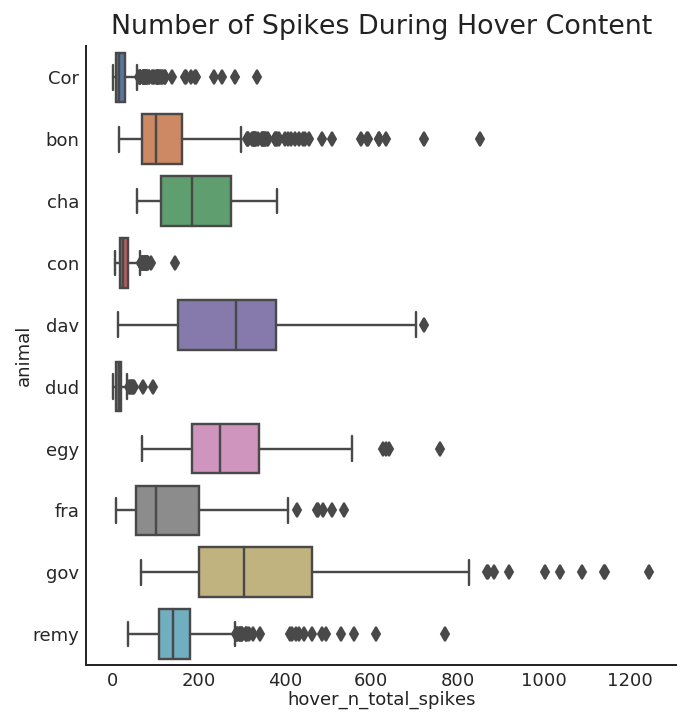

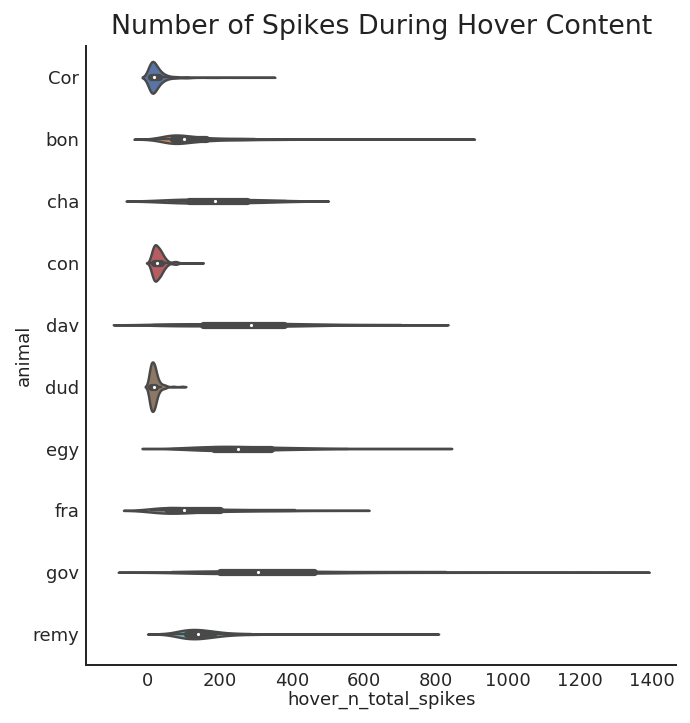

In [198]:
df = replay_info

# Probably need rate

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(), x="hover_n_total_spikes", y="animal", ci="sd", kind=kind,
    )
    plt.title("Number of Spikes During Hover Content")

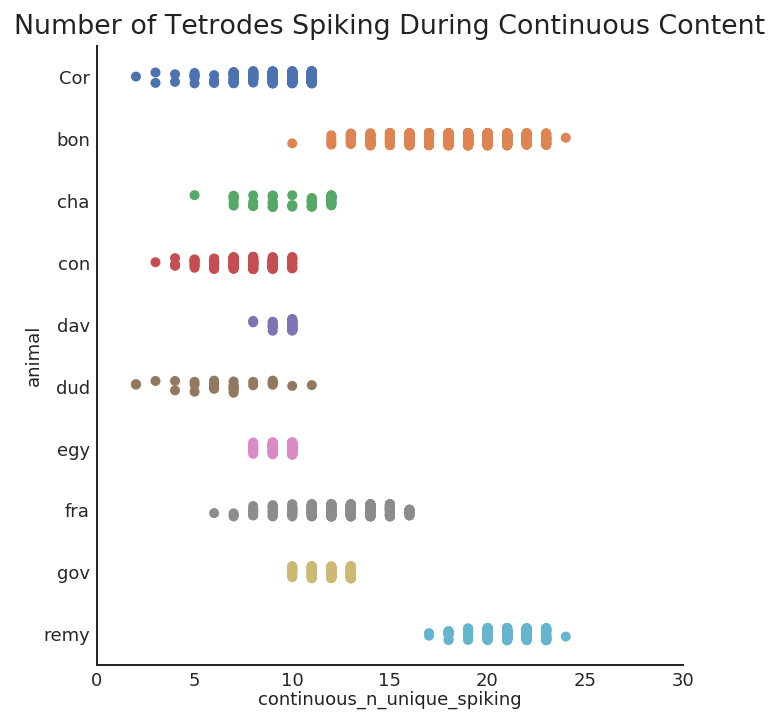

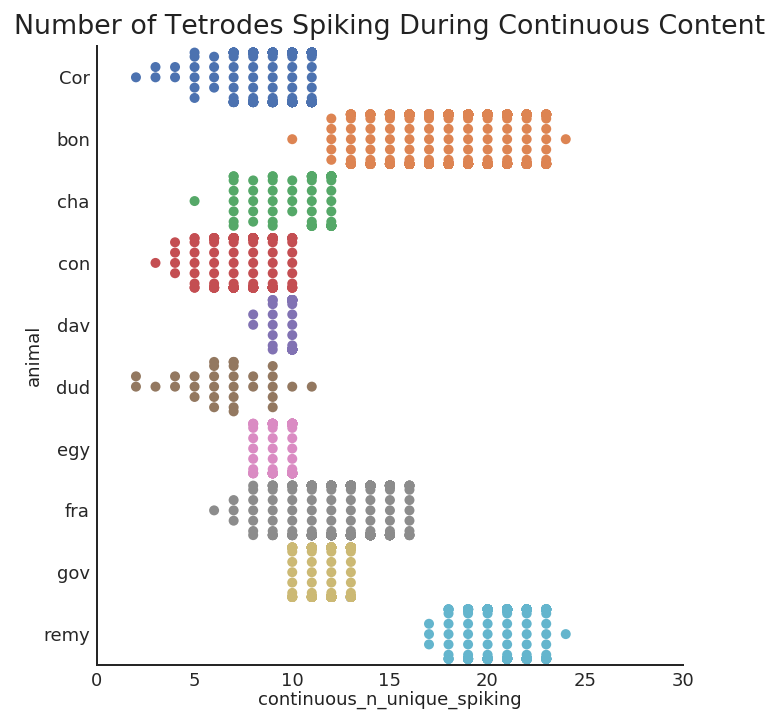

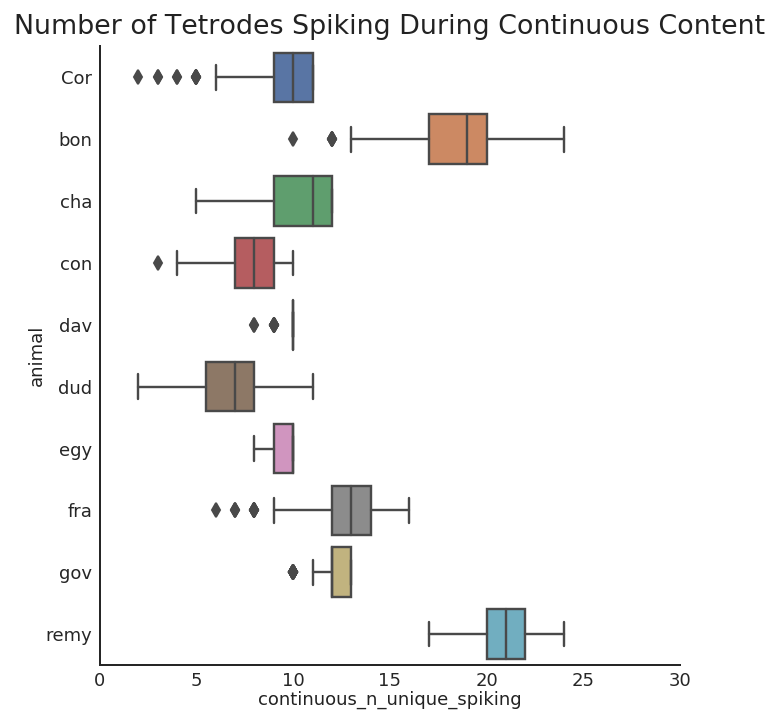

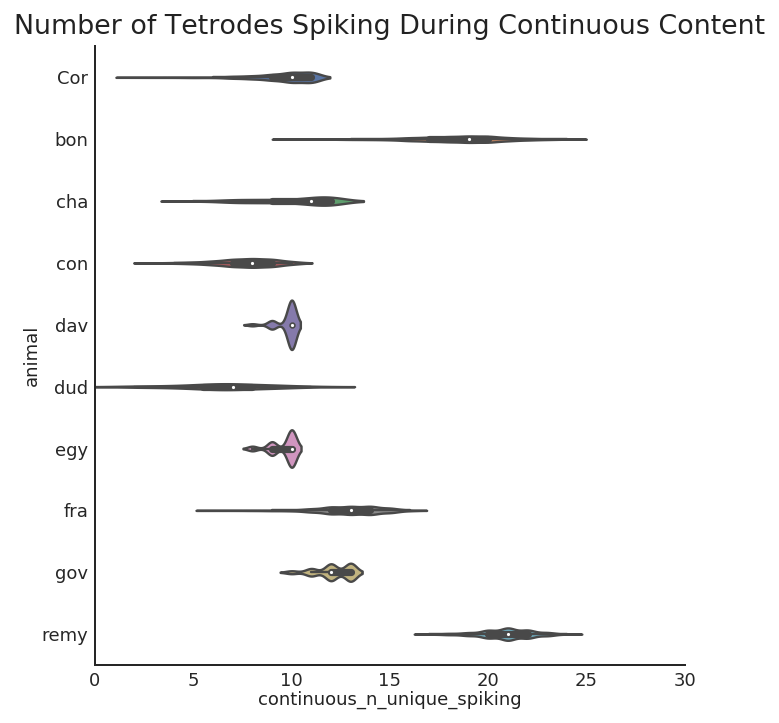

In [200]:
df = replay_info
# Need percentage of tetrodes spiking

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="continuous_n_unique_spiking",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 30))
    plt.title("Number of Tetrodes Spiking During Continuous Content")

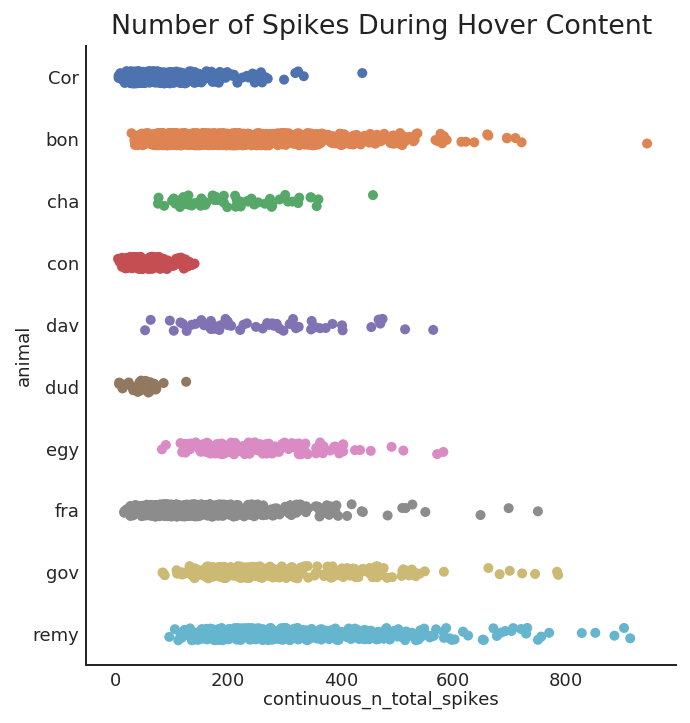

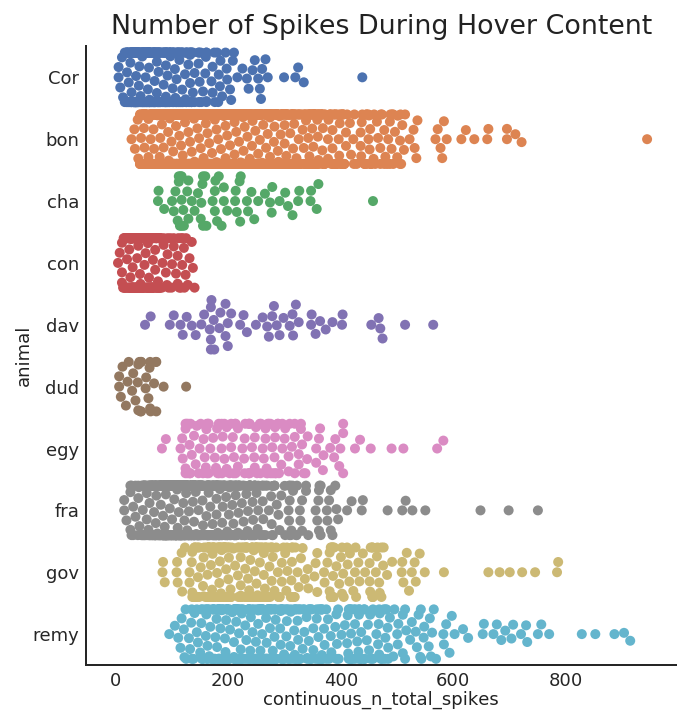

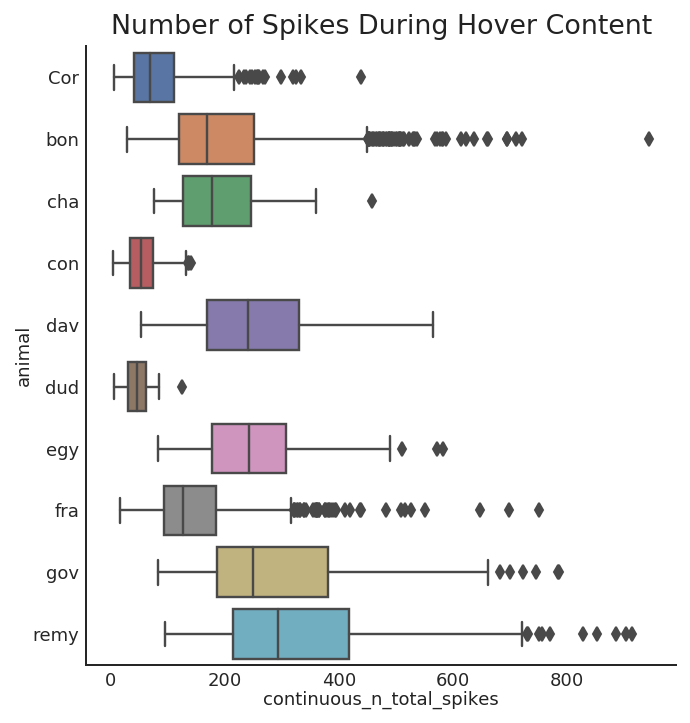

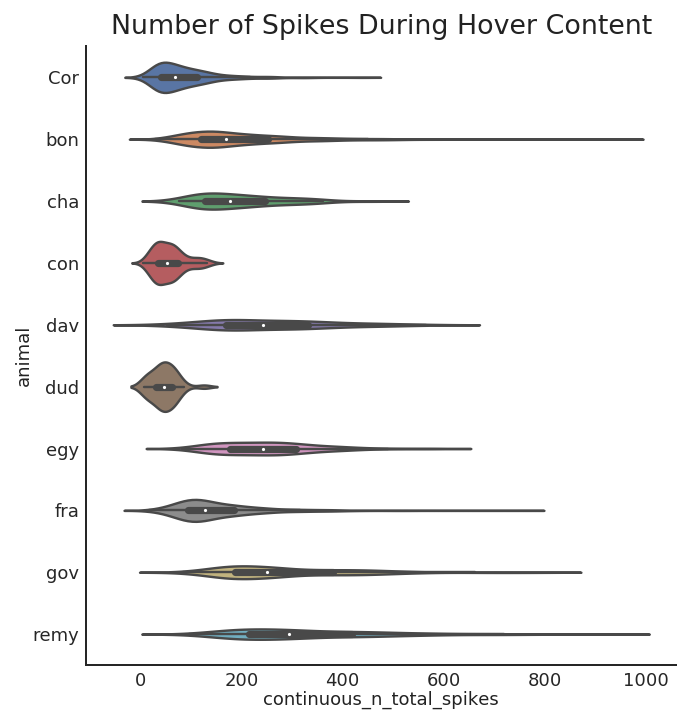

In [199]:
df = replay_info

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="continuous_n_total_spikes",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.title("Number of Spikes During Hover Content")

In [189]:
replay_info.columns.values

array(['actual_linear_distance', 'actual_linear_position2',
       'actual_speed', 'actual_velocity_center_well', 'actual_x_position',
       'actual_y_position', 'center_well_position', 'choice_position',
       'continuous', 'continuous_duration', 'continuous_max_probability',
       'continuous_max_time', 'continuous_min_time',
       'continuous_n_total_spikes', 'continuous_n_unique_spiking',
       'continuous_popultion_rate',
       'continuous_replay_distance_from_actual_position',
       'continuous_replay_distance_from_center_well',
       'continuous_replay_linear_position', 'continuous_replay_speed',
       'continuous_replay_total_displacement',
       'continuous_replay_total_distance',
       'continuous_replay_velocity_actual_position',
       'continuous_replay_velocity_center_well', 'duration', 'end_time',
       'fragmented', 'fragmented-continuous-mix',
       'fragmented-continuous-mix_duration',
       'fragmented-continuous-mix_max_probability',
       'fragmented

In [20]:
df = replay_info

replay_info.

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f4b3c9d50d0> (for post_execute):


KeyboardInterrupt: 